In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/MyDrive/without/data')
#os.chdir('/content/drive/MyDrive/thesis/Untitled')


In [ ]:
#B005X4PL1G
!pwd

/content/drive/MyDrive/without/data


In [ ]:
pip install --upgrade efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=10ae61976219133496dd30c1093a227babb399f545b5dc7ab6a1ad3ff907dd1e
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
"""Main method to train the model."""


#!/usr/bin/python

import argparse
import sys
import time
import datasets
import img_text_composition_models
import numpy as np
from torch.utils.tensorboard import SummaryWriter
#import test_retrieval
import torch
import torch.utils.data
from torch.utils.data import dataloader
import torchvision
from tqdm import tqdm as tqdm
import pdb
import time
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from matplotlib.ticker import MaxNLocator
import PIL
Dress_time = []
shirt_time=[]
Top_time = []

torch.set_num_threads(3)



In [ ]:
def load_dataset(opt):
  """Loads the input datasets."""
  print('Reading dataset ', opt.dataset)
  if opt.dataset == 'fashioniq':
    trainset = datasets.FashionIQ(
        anno_dir=opt.root_dir.format('annotation'),
        image_dir=opt.root_dir.format('images'),
        split_dir=opt.root_dir.format('public_split'),
        category= ['shirt'],
        split='train',
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.RandomCrop(224),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),            
            torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])
        ]))
        
  else:
    print('Invalid dataset', opt.dataset)
    sys.exit()

  print('trainset size:', len(trainset))
  return trainset


In [ ]:
def create_model_and_optimizer(opt, texts):
  """Builds the model and related optimizer."""
  print('Creating model and optimizer for', opt.model)
  if opt.model == 'imgonly':
    model = img_text_composition_models.SimpleModelImageOnly(
        texts, opt)
  elif opt.model == 'textonly':
    model = img_text_composition_models.SimpleModelTextOnly(
        texts, opt)
  elif opt.model == 'add':
    model = img_text_composition_models.Add(texts, opt)
  elif opt.model == 'concat':
    model = img_text_composition_models.Concat(texts, opt)
  elif opt.model == 'tirg':
    model = img_text_composition_models.TIRG(texts, opt)
  elif opt.model == 'tirg_lastconv':
    model = img_text_composition_models.TIRGLastConv(
        texts, opt)
  else:
    print('Invalid model', opt.model)
    print('available: imgonly, textonly, add, concat, tirg, tirg_lastconv')
    sys.exit()
  model = model.cuda()
  #model = model
  
  # create optimizer
  params = []
  per_params = []
  for name, param in model.named_parameters():
    per_params.append(param)
  params.append({'params': per_params})
  if opt.optimizer == 'SGD':
    optimizer = torch.optim.SGD(
        params, lr=opt.learning_rate, momentum=0.9, weight_decay=opt.weight_decay)
  elif opt.optimizer == 'Adam':
    optimizer = torch.optim.Adam(params, lr=opt.learning_rate)
  return model, optimizer


def train_loop(opt, logger, trainset, model, optimizer, DP_data=None):
  """Function for train loop"""
  print('Begin training')
  losses_tracking = {}
  best_eval = 0
  it = 0
  tic = time.time()
  df_loss=pd.DataFrame(columns=["epoch","batch_based_classification", "total training loss"])
  df_R_mean_TextOnly=pd.DataFrame(columns=["epoch","Recall_Mean"])
  for epoch in range(opt.num_epoch):
    # run trainning for 1 epoch
    model.train()
    
    trainloader = dataloader.DataLoader(trainset,
        batch_size=opt.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=opt.loader_num_workers)
    
    def training_1_iter(data, data_dp=None):
      # img1 = data['source_img_data']
      # img2 = data['target_img_data']
     
      img1 = data['source_img_data'].cuda()
      img2 = data['target_img_data'].cuda()
      mods = data['mod']['str']

      # compute loss
      losses = []
      if opt.loss == 'batch_based_classification':
        loss_value = model.compute_loss(
            img1, mods, img2, soft_triplet_loss=False)
      else:
        print('Invalid loss function', opt.loss)
        sys.exit()
      loss_name = opt.loss
      loss_weight = 1.0
      losses += [(loss_name, loss_weight, loss_value)]

      total_loss = sum([
          loss_weight * loss_value
          for loss_name, loss_weight, loss_value in losses
      ])
      assert not torch.isnan(total_loss)
      losses += [('total training loss', None, total_loss)]

      # track losses
      for loss_name, loss_weight, loss_value in losses:
        if not loss_name in losses_tracking:
          losses_tracking[loss_name] = []
        losses_tracking[loss_name].append(float(loss_value))
    
      # gradient descend
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
    
    count_dp_idx = 0
    for data in tqdm(trainloader, desc='Training for epoch ' + str(epoch)):
      it = it + 1
      training_1_iter(data)
    
    # show/log stats
    print('It', it, 'epoch', epoch, 'Elapsed time', round(time.time() - tic, 4))
    tic = time.time()
    for loss_name in losses_tracking:
      avg_loss = np.mean(losses_tracking[loss_name][-len(trainloader):])
      if loss_name=="batch_based_classification":
        batch_loss=round(avg_loss, 5)
      else:
        training_loss=round(avg_loss, 5)
      print('    Loss', loss_name, round(avg_loss, 4))
    row=[epoch,batch_loss,training_loss]
    df_loss.loc[epoch] = row

    # test
    if epoch % opt.eval_frequency == 0:
      tests = []
      all_sims = {}
      rsum = 0
      for dataname in trainset.data_name:
        t, sims, nn_result = testResults(opt, model, trainset, dataname)
        all_sims[dataname] = sims
        for metric_name, metric_value in t:
          tests += [(metric_name, metric_value)]
          rsum += metric_value
      tests += [('rmean', rsum / 6)]
      for metric_name, metric_value in tests:
        logger.add_scalar(metric_name, metric_value, it)
        if metric_name=="rmean":
          row=[epoch,metric_value]
          df_R_mean_TextOnly.loc[epoch]=row
        print('    ', metric_name, round(metric_value, 2))

      if rsum > best_eval:
        best_eval = rsum
        # save checkpoint
        for dataname in trainset.data_name:
          np.save(opt.log_dir + '/val.{}.{}.scores.npy'.format(dataname, opt.model), all_sims[dataname])
        torch.save({
            'it': it,
            'opt': opt,
            'model_state_dict': model.state_dict(),
        },
        logger.file_writer.get_logdir() + '/best_checkpoint.pth')
  print('Finished training')
  return df_loss, df_R_mean_TextOnly
  

In [ ]:
def test(opt, testset, model):
  print('Begin testing')
  tests = []
  rsum = 0
  for dataname in testset.data_name:
    t, sims, nn_result = testResults(opt, model, testset, dataname)
    np.save(opt.log_dir + '/val.{}.{}.scores.npy'.format(dataname, opt.model), sims)

    for metric_name, metric_value in t:
      tests += [(metric_name, metric_value)]
      rsum += metric_value

  tests += [('RecallMean', rsum / 6)]
  for metric_name, metric_value in tests:
    print('    ', metric_name, round(metric_value, 2))
  print('Finished testing')
  return nn_result

def load_state_dicts(opt, model):
  state_dict = torch.load(opt.resume_file, map_location=lambda storage, loc: storage)['model_state_dict']
  num_resumed_vars = 0
  own_state_dict = model.state_dict()
  new_state_dict = {}
  for varname, varvalue in state_dict.items():
    if varname in own_state_dict:
      new_state_dict[varname] = varvalue
      num_resumed_vars += 1
  own_state_dict.update(new_state_dict)
  model.load_state_dict(own_state_dict)
  print('number of resumed variables: {}'.format(num_resumed_vars))



In [ ]:
"""Evaluates the retrieval model."""
# A fuction to calculate evaluation metrics refere it.

# dataname2id = {'dress': 0, 'shirt': 1, 'toptee': 2}
# datanames = ['dress', 'shirt', 'toptee']

def testResults(opt, model, testset, dataname):
  """Tests a model over the given testset."""
  model.eval()
  #dataname_id = dataname2id[dataname]
  test_queries = testset.get_test_queries()[0]
  test_targets = testset.get_test_targets()[0]

  all_queries = []
  all_imgs = []
  if test_queries:
    # compute test query features
    imgs = []
    mods = []
    for t in tqdm(test_queries):
      imgs += [t['source_img_data']]
      mods += [t['mod']['str']]
      if len(imgs) >= opt.batch_size or t is test_queries[-1]:
        if 'torch' not in str(type(imgs[0])):
          imgs = [torch.from_numpy(d).float() for d in imgs]
        imgs = torch.stack(imgs).float().cuda()
	#   imgs = torch.stack(imgs).float()
        f = model.compose_img_text(imgs, mods).data.cpu().numpy()
        all_queries += [f]
        imgs = []
        mods = []
    all_queries = np.concatenate(all_queries)
    
    # compute all image features
    imgs = []
    logits = []
    for t in tqdm(test_targets):
      imgs += [t['target_img_data']]
      if len(imgs) >= opt.batch_size or t is test_targets[-1]:
        if 'torch' not in str(type(imgs[0])):
          imgs = [torch.from_numpy(d).float() for d in imgs]
        imgs = torch.stack(imgs).float().cuda()
	#imgs = torch.stack(imgs).float()
        imgs = model.extract_img_feature(imgs).data.cpu().numpy()
        all_imgs += [imgs]
        imgs = []
    all_imgs = np.concatenate(all_imgs)
    
  # feature normalization
  for i in range(all_queries.shape[0]):
    all_queries[i, :] /= np.linalg.norm(all_queries[i, :])
  for i in range(all_imgs.shape[0]):
    all_imgs[i, :] /= np.linalg.norm(all_imgs[i, :])

  # match test queries to target images, get nearest neighbors
  sims = all_queries.dot(all_imgs.T)

  for i, t in enumerate(test_queries):
    sims[i, t['source_img_id']] = -10e10  # remove query image

  nn_result = [np.argsort(-sims[i, :])[:50] for i in range(sims.shape[0])]

  # compute recalls
  out = []
  for k in [1, 3, 5, 10, 20, 50]:
    r = 0.0
    for i, nns in enumerate(nn_result):
      if test_queries[i]['target_img_id'] in nns[:k]:
        r += 1
    r = 100 * r / len(nn_result)
    out += [('{}_r{}'.format(dataname, k), r)]
  return out, sims, nn_result

In [ ]:
def show_source(source_id):
  image_dir=opt.root_dir.format('images')
  fig = figure(figsize = (8,8))
  idx = test_queries[source_id]['source_img']
  img_path = image_dir + '/' +idx+ ".jpg"
  print("Textual Query =  ", test_queries[source_id]['mod']['str'].replace("<BOS>", " ").replace("<EOS>", " "))
  a=fig.add_subplot(1,2,1)
  image = imread(img_path)
  imshow(image)
  plt.title('Qurey Image')
  axis('off')

  idx = test_queries[source_id]['target_img']
  img_path = image_dir + '/' +idx+ ".jpg"

  a=fig.add_subplot(1,2,2)
  image = imread(img_path)
  imshow(image)
  plt.title('Target Image')
  axis('off')


In [ ]:

def get_result(array_list):
  result_files = []
  print(len(array_list))
  for i in range(len(array_list)):
    for t in test_queries:
      if t['source_img_id']==array_list[i]:
        idx = t['source_img']
        image_dir=opt.root_dir.format('images')
        img_path = image_dir + '/' +idx+ ".jpg"
        result_files += [img_path]
    
  return result_files
def show_result_all(result_files):
    
    
    fig = figure(figsize = (25,25))
    number_of_files = len(result_files)
    
    for i in range(5):
        a=fig.add_subplot(1,5,i+1)
        image = imread(result_files[i])
        imshow(image)
        if i==4:
          plt.title("Results ")
        axis('off')
    

# **Text Only Model**

In [ ]:
def parse_opt():
  """Parses the input arguments."""
  parser = argparse.ArgumentParser()
  parser.add_argument('-f', type=str, default='')
  parser.add_argument('--dataset', type=str, default='fashioniq')
  parser.add_argument('--root_dir', type=str, default='./{}')
  parser.add_argument('--log_dir', type=str, default='./runs')
  parser.add_argument('--model', type=str, default='textonly')
  parser.add_argument('--img_encoder', type=str, default='efficientnet')
  parser.add_argument('--text_encoder', type=str, default='lstm')
  parser.add_argument('--embed_dim', type=int, default=1024)
  parser.add_argument('--optimizer', type=str, default='Adam') # SGD Adam
  parser.add_argument('--learning_rate', type=float, default=1e-4)
  parser.add_argument(
      '--learning_rate_decay_patient', type=int, default=5)
  parser.add_argument('--eval_frequency', type=int, default=1)
  parser.add_argument('--lr_div', type=float, default=0.5) # 0.1
  parser.add_argument('--batch_size', type=int, default=32)
  parser.add_argument('--weight_decay', type=float, default=1e-6)
  parser.add_argument('--num_epoch', type=int, default=15)
  parser.add_argument('--loss', type=str, default='batch_based_classification')
  parser.add_argument('--loader_num_workers', type=int, default=2)
  parser.add_argument('--resume_file', default='./runs/best_checkpoint.pth')
  
  args = parser.parse_args()
  return args


In [ ]:
opt = parse_opt()
print('Arguments:')
for k in opt.__dict__.keys():
    print('    ', k, ':', str(opt.__dict__[k]))

Arguments:
     f : /root/.local/share/jupyter/runtime/kernel-2b8b05d2-d887-4c17-afd6-0f1c691eead8.json
     dataset : fashioniq
     root_dir : ./{}
     log_dir : ./runs
     model : textonly
     img_encoder : efficientnet
     text_encoder : lstm
     embed_dim : 1024
     optimizer : Adam
     learning_rate : 0.0001
     learning_rate_decay_patient : 5
     eval_frequency : 1
     lr_div : 0.5
     batch_size : 32
     weight_decay : 1e-06
     num_epoch : 15
     loss : batch_based_classification
     loader_num_workers : 2
     resume_file : ./runs/best_checkpoint.pth


# Training

In [ ]:
logger = SummaryWriter(opt.log_dir)
print('Log files saved to', logger.file_writer.get_logdir())
for k in opt.__dict__.keys():
  logger.add_text(k, str(opt.__dict__[k]))
    
trainset = load_dataset(opt)

Log files saved to ./runs


In [ ]:
pickle_out = open("trainset_shirt_final.pickle","wb")
pickle.dump(trainset, pickle_out)

pickle_in = open("trainset_shirt_final.pickle","rb")
trainset = pickle.load(pickle_in)


In [ ]:
trainset_test_queries = trainset.get_test_queries()[0]
print(len(trainset_test_queries))

202


In [ ]:
model, optimizer = create_model_and_optimizer(opt, None)

start_time = time.time()
df_loss_TextOnly, df_R_mean_TextOnly= train_loop(opt, logger, trainset, model, optimizer)    
shirt_time.append(time.time() - start_time)
logger.close()
df_loss_TextOnly.head()

Creating model and optimizer for textonly
Loaded pretrained weights for efficientnet-b0
Begin training


Training for epoch 0: 100%|██████████| 187/187 [01:46<00:00,  1.76it/s]


It 187 epoch 0 Elapsed time 106.248
    Loss batch_based_classification 3.1181
    Loss total training loss 3.1181


100%|██████████| 3443/3443 [00:15<00:00, 219.19it/s]


     shirt_r1 0.99
     shirt_r3 2.48
     shirt_r5 3.96
     shirt_r10 10.89
     shirt_r20 15.35
     shirt_r50 24.75
     rmean 9.74


Training for epoch 1: 100%|██████████| 187/187 [01:45<00:00,  1.77it/s]


It 374 epoch 1 Elapsed time 123.9226
    Loss batch_based_classification 2.2208
    Loss total training loss 2.2208


100%|██████████| 3443/3443 [00:15<00:00, 220.88it/s]


     shirt_r1 3.96
     shirt_r3 9.9
     shirt_r5 13.86
     shirt_r10 21.78
     shirt_r20 29.21
     shirt_r50 47.52
     rmean 21.04


Training for epoch 2: 100%|██████████| 187/187 [01:45<00:00,  1.77it/s]


It 561 epoch 2 Elapsed time 122.0265
    Loss batch_based_classification 1.7977
    Loss total training loss 1.7977


100%|██████████| 3443/3443 [00:15<00:00, 221.58it/s]


     shirt_r1 5.45
     shirt_r3 10.89
     shirt_r5 15.84
     shirt_r10 28.71
     shirt_r20 39.6
     shirt_r50 58.42
     rmean 26.49


Training for epoch 3: 100%|██████████| 187/187 [01:45<00:00,  1.77it/s]


It 748 epoch 3 Elapsed time 121.8181
    Loss batch_based_classification 1.5122
    Loss total training loss 1.5122


100%|██████████| 3443/3443 [00:15<00:00, 220.95it/s]


     shirt_r1 8.91
     shirt_r3 19.31
     shirt_r5 25.25
     shirt_r10 35.15
     shirt_r20 46.04
     shirt_r50 67.82
     rmean 33.75


Training for epoch 4: 100%|██████████| 187/187 [01:45<00:00,  1.77it/s]


It 935 epoch 4 Elapsed time 121.8511
    Loss batch_based_classification 1.3082
    Loss total training loss 1.3082


100%|██████████| 3443/3443 [00:15<00:00, 221.49it/s]


     shirt_r1 13.86
     shirt_r3 22.77
     shirt_r5 31.19
     shirt_r10 43.56
     shirt_r20 61.39
     shirt_r50 76.73
     rmean 41.58


Training for epoch 5: 100%|██████████| 187/187 [01:45<00:00,  1.77it/s]


It 1122 epoch 5 Elapsed time 121.9085
    Loss batch_based_classification 1.1331
    Loss total training loss 1.1331


100%|██████████| 3443/3443 [00:15<00:00, 221.57it/s]


     shirt_r1 16.83
     shirt_r3 31.68
     shirt_r5 37.62
     shirt_r10 51.49
     shirt_r20 66.83
     shirt_r50 81.68
     rmean 47.69


Training for epoch 6: 100%|██████████| 187/187 [01:45<00:00,  1.77it/s]


It 1309 epoch 6 Elapsed time 122.077
    Loss batch_based_classification 1.0089
    Loss total training loss 1.0089


100%|██████████| 3443/3443 [00:15<00:00, 221.00it/s]


     shirt_r1 17.82
     shirt_r3 39.11
     shirt_r5 46.53
     shirt_r10 62.38
     shirt_r20 74.75
     shirt_r50 86.63
     rmean 54.54


Training for epoch 7: 100%|██████████| 187/187 [01:45<00:00,  1.77it/s]


It 1496 epoch 7 Elapsed time 122.2408
    Loss batch_based_classification 0.8666
    Loss total training loss 0.8666


100%|██████████| 3443/3443 [00:15<00:00, 221.51it/s]


     shirt_r1 31.68
     shirt_r3 46.53
     shirt_r5 51.98
     shirt_r10 67.33
     shirt_r20 77.72
     shirt_r50 92.08
     rmean 61.22


Training for epoch 8: 100%|██████████| 187/187 [01:45<00:00,  1.77it/s]


It 1683 epoch 8 Elapsed time 121.9428
    Loss batch_based_classification 0.8017
    Loss total training loss 0.8017


100%|██████████| 3443/3443 [00:15<00:00, 221.89it/s]


     shirt_r1 30.2
     shirt_r3 50.99
     shirt_r5 61.88
     shirt_r10 75.74
     shirt_r20 84.16
     shirt_r50 95.05
     rmean 66.34


Training for epoch 9: 100%|██████████| 187/187 [01:45<00:00,  1.77it/s]


It 1870 epoch 9 Elapsed time 122.1313
    Loss batch_based_classification 0.6928
    Loss total training loss 0.6928


100%|██████████| 3443/3443 [00:15<00:00, 220.96it/s]


     shirt_r1 39.11
     shirt_r3 56.93
     shirt_r5 68.81
     shirt_r10 78.71
     shirt_r20 90.1
     shirt_r50 98.51
     rmean 72.03


Training for epoch 10: 100%|██████████| 187/187 [01:45<00:00,  1.77it/s]


It 2057 epoch 10 Elapsed time 122.0515
    Loss batch_based_classification 0.6011
    Loss total training loss 0.6011


100%|██████████| 3443/3443 [00:15<00:00, 221.95it/s]


     shirt_r1 41.58
     shirt_r3 65.84
     shirt_r5 76.24
     shirt_r10 85.15
     shirt_r20 92.57
     shirt_r50 99.01
     rmean 76.73


Training for epoch 11: 100%|██████████| 187/187 [01:45<00:00,  1.77it/s]


It 2244 epoch 11 Elapsed time 121.743
    Loss batch_based_classification 0.5353
    Loss total training loss 0.5353


100%|██████████| 3443/3443 [00:15<00:00, 222.43it/s]


     shirt_r1 50.0
     shirt_r3 69.31
     shirt_r5 76.73
     shirt_r10 82.18
     shirt_r20 91.58
     shirt_r50 98.51
     rmean 78.05


Training for epoch 12: 100%|██████████| 187/187 [01:45<00:00,  1.77it/s]


It 2431 epoch 12 Elapsed time 121.8101
    Loss batch_based_classification 0.4789
    Loss total training loss 0.4789


100%|██████████| 3443/3443 [00:15<00:00, 221.19it/s]


     shirt_r1 52.48
     shirt_r3 75.25
     shirt_r5 83.17
     shirt_r10 94.06
     shirt_r20 98.51
     shirt_r50 99.5
     rmean 83.83


Training for epoch 13: 100%|██████████| 187/187 [01:45<00:00,  1.77it/s]


It 2618 epoch 13 Elapsed time 122.0179
    Loss batch_based_classification 0.454
    Loss total training loss 0.454


100%|██████████| 3443/3443 [00:15<00:00, 220.88it/s]


     shirt_r1 56.93
     shirt_r3 78.71
     shirt_r5 88.61
     shirt_r10 95.54
     shirt_r20 98.02
     shirt_r50 100.0
     rmean 86.3


Training for epoch 14: 100%|██████████| 187/187 [01:45<00:00,  1.77it/s]


It 2805 epoch 14 Elapsed time 121.9933
    Loss batch_based_classification 0.4109
    Loss total training loss 0.4109


100%|██████████| 3443/3443 [00:15<00:00, 221.71it/s]


     shirt_r1 62.38
     shirt_r3 82.18
     shirt_r5 89.11
     shirt_r10 96.04
     shirt_r20 99.01
     shirt_r50 100.0
     rmean 88.12
Finished training


epoch  batch_based_classification  total training loss
0    0.0                     3.11811              3.11811
1    1.0                     2.22084              2.22084
2    2.0                     1.79774              1.79774
3    3.0                     1.51217              1.51217
4    4.0                     1.30820              1.30820

In [ ]:
df_loss_TextOnly

epoch  batch_based_classification  total training loss
0     0.0                     3.11811              3.11811
1     1.0                     2.22084              2.22084
2     2.0                     1.79774              1.79774
3     3.0                     1.51217              1.51217
4     4.0                     1.30820              1.30820
5     5.0                     1.13307              1.13307
6     6.0                     1.00891              1.00891
7     7.0                     0.86659              0.86659
8     8.0                     0.80170              0.80170
9     9.0                     0.69279              0.69279
10   10.0                     0.60109              0.60109
11   11.0                     0.53528              0.53528
12   12.0                     0.47885              0.47885
13   13.0                     0.45400              0.45400
14   14.0                     0.41089              0.41089

In [ ]:
df_R_mean_TextOnly

epoch  Recall_Mean
0     0.0     9.735974
1     1.0    21.039604
2     2.0    26.485149
3     3.0    33.745875
4     4.0    41.584158
5     5.0    47.689769
6     6.0    54.537954
7     7.0    61.221122
8     8.0    66.336634
9     9.0    72.029703
10   10.0    76.732673
11   11.0    78.052805
12   12.0    83.828383
13   13.0    86.303630
14   14.0    88.118812

In [ ]:
shirt_time

[1832.0176117420197]

# **Testing**

In [ ]:
#tmp_split = 'val'
tmp_split = 'test'
    
testset = datasets.FashionIQ(
    anno_dir=opt.root_dir.format('annotation'),
    image_dir=opt.root_dir.format('images'),
    split_dir=opt.root_dir.format('public_split'),
    category= ['shirt'],
    split=tmp_split,
    transform=torchvision.transforms.Compose([
                                              torchvision.transforms.Resize(256),
                                              torchvision.transforms.CenterCrop(224),
                                              torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                              ]
                                             )
    )

captions size 2038


In [ ]:
pickle_out1 = open("testset_shirt_final.pickle","wb")
pickle.dump(testset, pickle_out1)

pickle_in1 = open("testset_shirt_final.pickle","rb")
testset = pickle.load(pickle_in1)


In [ ]:
test_queries = testset.get_test_queries()[0]
print(len(test_queries))

262


In [ ]:
model, optimizer = create_model_and_optimizer(opt, None)
# state_dicts = torch.load(opt.resume_file, map_location=lambda storage, loc: storage)['model_state_dict']
# model.load_state_dict(state_dicts)
nn_result_TextOnly=test(opt, testset, model)


Begin testing


100%|██████████| 2191/2191 [00:10<00:00, 215.21it/s]


     shirt_r1 1.53
     shirt_r3 7.63
     shirt_r5 10.31
     shirt_r10 14.89
     shirt_r20 24.05
     shirt_r50 39.31
     RecallMean 16.28
Finished testing


**Qualitative Results**

In [ ]:
test_queries = testset.get_test_queries()[0]
print(test_queries[1])

{'source_img_id': 1377, 'source_img_data': tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.640

In [ ]:
nn_result_TextOnly[1]

array([ 195,  381, 2164, 1342, 1741, 1683,  377, 1654, 1844,  546,  455,
       2129,  490,  281, 1958, 1107,  967, 1340, 1377,  959, 1946,   83,
       1293, 1003,  355, 1379, 1862, 1752,  719, 1779,  841, 1902, 1924,
        726,  648, 1949, 1555, 2038, 2008,  674, 1424,  318, 2003, 1587,
       1835, 2096,  738,  706,  383,  188])

In [ ]:
get_result(nn_result_TextOnly[1])

50


['./images/B008YDEB6E.jpg',
 './images/B0079G6CXC.jpg',
 './images/B009E739Q2.jpg',
 './images/B0060RMLPO.jpg',
 './images/B0060RMLPO.jpg',
 './images/B00EYSAIPG.jpg',
 './images/B007KHTV24.jpg',
 './images/B007KHTV24.jpg',
 './images/B002GU7D5M.jpg',
 './images/B002GU7D5M.jpg',
 './images/B00E00SG7K.jpg',
 './images/B00711V8Y8.jpg',
 './images/B00715FFX4.jpg',
 './images/B0080E53WI.jpg',
 './images/B00CLF5ZFC.jpg']

In [ ]:
get_result(nn_result_TextOnly[2])

50


['./images/B00595TNMM.jpg',
 './images/B00DDX15TG.jpg',
 './images/B004OHYU4M.jpg',
 './images/B004OHYU4M.jpg',
 './images/B00F4MXLRI.jpg',
 './images/B007M8PCAQ.jpg',
 './images/B007M8PCAQ.jpg',
 './images/B008UH8MY6.jpg',
 './images/B008UH8MY6.jpg',
 './images/B00B89H8NO.jpg',
 './images/B00C17P8W0.jpg',
 './images/B007XD6RYK.jpg',
 './images/B005QN26TE.jpg',
 './images/B0083FTUI2.jpg',
 './images/B00E3HDPMQ.jpg',
 './images/B00FQANLX2.jpg',
 './images/B00FQANLX2.jpg']

In [ ]:
nn_result_TextOnly[1]

array([1109,  219,  103, 1272,  148, 1129, 1079,  181,  170,    6,  126,
       1499,  248,  824, 1173,  233,  519,  290,  461,  445,  373,   16,
        536, 1198,  557, 1481, 1553, 1444, 1025,  697,  255, 1420, 1449,
        969,  386,  388,  156,  177,  463,  108,  110,  342, 1240, 1472,
       1684, 1255, 1376,  858,  332,  507])

Textual Query =     is a lighter color with a cat graphic <AND> is lighter and more graphic  
50


(None, None)

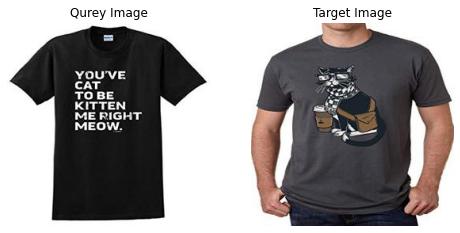

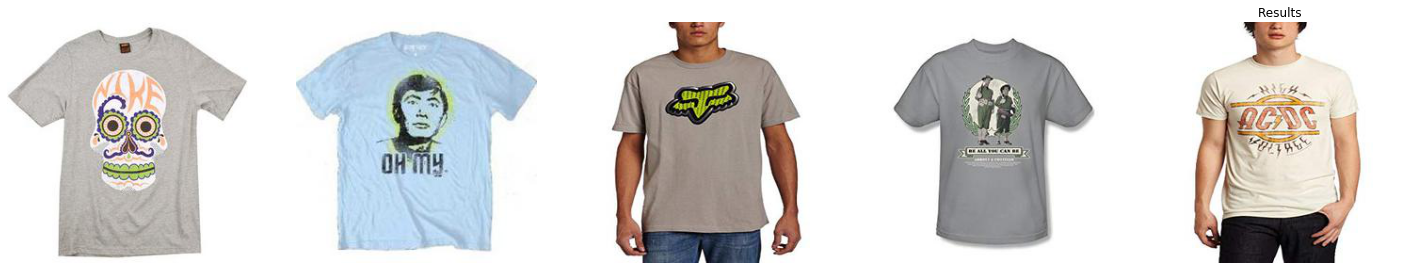

In [ ]:
show_source(30),show_result_all(get_result(nn_result_TextOnly[30]))

Textual Query =     is red and a tshirt <AND> more warmer colors  
50


(None, None)

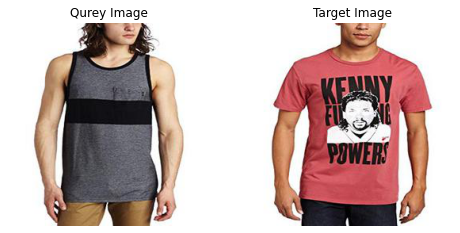

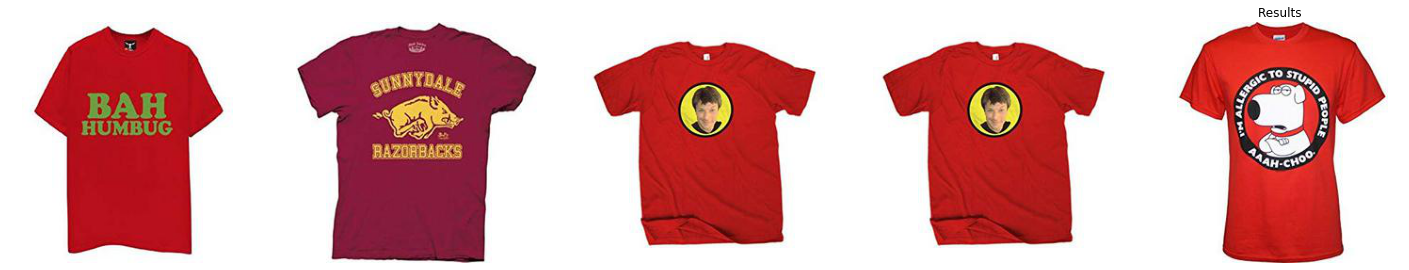

In [ ]:
show_source(1),show_result_all(get_result(nn_result_TextOnly[1]))

Textual Query =     the shirt is gray in color with white writing <AND> is faded  
50


(None, None)

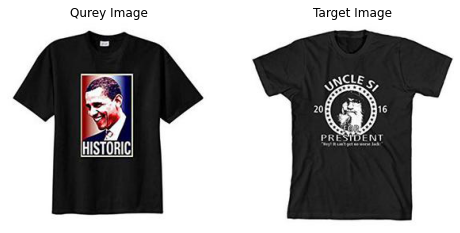

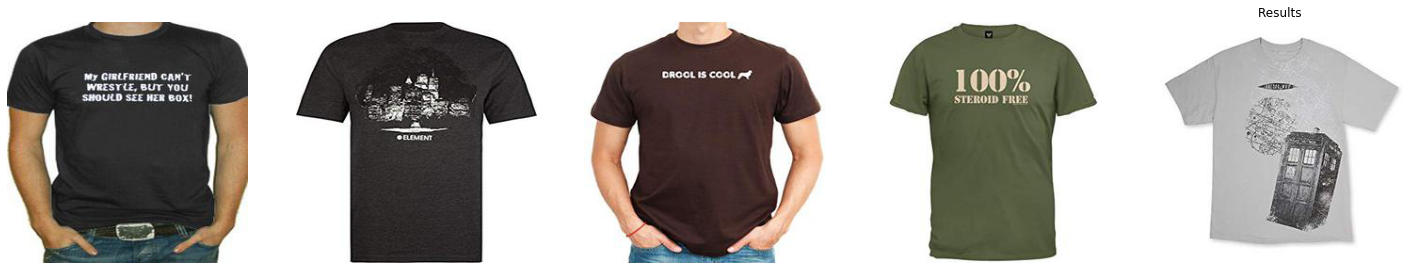

In [ ]:
show_source(50),show_result_all(get_result(nn_result_TextOnly[50]))

# **img Only Efficient-Net**

In [ ]:
def parse_opt():
  """Parses the input arguments."""
  parser = argparse.ArgumentParser()
  parser.add_argument('-f', type=str, default='')
  parser.add_argument('--dataset', type=str, default='fashioniq')
  parser.add_argument('--root_dir', type=str, default='./{}')
  parser.add_argument('--log_dir', type=str, default='./runs')
  parser.add_argument('--model', type=str, default='imgonly')
  parser.add_argument('--img_encoder', type=str, default='efficientnet')
  parser.add_argument('--text_encoder', type=str, default='lstm')
  parser.add_argument('--embed_dim', type=int, default=1024)
  parser.add_argument('--optimizer', type=str, default='Adam') # SGD Adam
  parser.add_argument('--learning_rate', type=float, default=1e-4)
  parser.add_argument(
      '--learning_rate_decay_patient', type=int, default=5)
  parser.add_argument('--eval_frequency', type=int, default=1)
  parser.add_argument('--lr_div', type=float, default=0.5) # 0.1
  parser.add_argument('--batch_size', type=int, default=32)
  parser.add_argument('--weight_decay', type=float, default=1e-6)
  parser.add_argument('--num_epoch', type=int, default=15)
  parser.add_argument('--loss', type=str, default='batch_based_classification')
  parser.add_argument('--loader_num_workers', type=int, default=2)
  parser.add_argument('--resume_file', default='./runs/best_checkpoint.pth')
  
  args = parser.parse_args()
  return args
opt = parse_opt()

Training

In [ ]:
model, optimizer = create_model_and_optimizer(opt, None)
# if opt.resume_file != None:
#   load_state_dicts(opt, model)

start_time = time.time()
df_loss_ImgOnly_Effi, df_R_mean_ImgOnly_Effi= train_loop(opt, logger, trainset, model, optimizer)    
shirt_time.append(time.time() - start_time)
logger.close()
df_loss_ImgOnly_Effi.head()


Creating model and optimizer for imgonly
Loaded pretrained weights for efficientnet-b0
Begin training


Training for epoch 0: 100%|██████████| 187/187 [03:06<00:00,  1.00it/s]


It 187 epoch 0 Elapsed time 186.9598
    Loss batch_based_classification 2.8751
    Loss total training loss 2.8751


100%|██████████| 3443/3443 [00:15<00:00, 220.60it/s]


     shirt_r1 3.47
     shirt_r3 6.44
     shirt_r5 9.41
     shirt_r10 14.85
     shirt_r20 20.79
     shirt_r50 32.18
     rmean 14.52


Training for epoch 1: 100%|██████████| 187/187 [03:06<00:00,  1.00it/s]


It 374 epoch 1 Elapsed time 203.7968
    Loss batch_based_classification 2.5257
    Loss total training loss 2.5257


100%|██████████| 3443/3443 [00:15<00:00, 220.83it/s]


     shirt_r1 3.47
     shirt_r3 10.4
     shirt_r5 15.35
     shirt_r10 19.8
     shirt_r20 26.73
     shirt_r50 39.6
     rmean 19.22


Training for epoch 2: 100%|██████████| 187/187 [03:06<00:00,  1.00it/s]


It 561 epoch 2 Elapsed time 203.8998
    Loss batch_based_classification 2.2807
    Loss total training loss 2.2807


100%|██████████| 3443/3443 [00:15<00:00, 218.94it/s]


     shirt_r1 5.94
     shirt_r3 14.36
     shirt_r5 17.82
     shirt_r10 26.73
     shirt_r20 34.16
     shirt_r50 46.53
     rmean 24.26


Training for epoch 3: 100%|██████████| 187/187 [03:06<00:00,  1.00it/s]


It 748 epoch 3 Elapsed time 203.9733
    Loss batch_based_classification 2.0926
    Loss total training loss 2.0926


100%|██████████| 3443/3443 [00:15<00:00, 220.77it/s]


     shirt_r1 8.91
     shirt_r3 18.32
     shirt_r5 21.78
     shirt_r10 31.19
     shirt_r20 39.11
     shirt_r50 51.49
     rmean 28.47


Training for epoch 4: 100%|██████████| 187/187 [03:06<00:00,  1.00it/s]


It 935 epoch 4 Elapsed time 203.9906
    Loss batch_based_classification 1.9214
    Loss total training loss 1.9214


100%|██████████| 3443/3443 [00:15<00:00, 220.94it/s]


     shirt_r1 7.92
     shirt_r3 18.32
     shirt_r5 24.26
     shirt_r10 38.12
     shirt_r20 47.03
     shirt_r50 61.88
     rmean 32.92


Training for epoch 5: 100%|██████████| 187/187 [03:06<00:00,  1.00it/s]


It 1122 epoch 5 Elapsed time 203.7686
    Loss batch_based_classification 1.7371
    Loss total training loss 1.7371


100%|██████████| 3443/3443 [00:15<00:00, 221.47it/s]


     shirt_r1 8.42
     shirt_r3 22.77
     shirt_r5 31.19
     shirt_r10 42.08
     shirt_r20 53.47
     shirt_r50 69.31
     rmean 37.87


Training for epoch 6: 100%|██████████| 187/187 [03:06<00:00,  1.00it/s]


It 1309 epoch 6 Elapsed time 203.567
    Loss batch_based_classification 1.6009
    Loss total training loss 1.6009


100%|██████████| 3443/3443 [00:15<00:00, 220.87it/s]


     shirt_r1 13.37
     shirt_r3 25.74
     shirt_r5 34.65
     shirt_r10 46.04
     shirt_r20 60.89
     shirt_r50 74.26
     rmean 42.49


Training for epoch 7: 100%|██████████| 187/187 [03:06<00:00,  1.00it/s]


It 1496 epoch 7 Elapsed time 203.9245
    Loss batch_based_classification 1.4588
    Loss total training loss 1.4588


100%|██████████| 3443/3443 [00:15<00:00, 221.44it/s]


     shirt_r1 14.36
     shirt_r3 28.22
     shirt_r5 40.59
     shirt_r10 52.48
     shirt_r20 64.85
     shirt_r50 79.21
     rmean 46.62


Training for epoch 8: 100%|██████████| 187/187 [03:06<00:00,  1.00it/s]


It 1683 epoch 8 Elapsed time 203.8817
    Loss batch_based_classification 1.3297
    Loss total training loss 1.3297


100%|██████████| 3443/3443 [00:15<00:00, 221.10it/s]


     shirt_r1 18.32
     shirt_r3 34.65
     shirt_r5 45.05
     shirt_r10 59.9
     shirt_r20 72.28
     shirt_r50 84.65
     rmean 52.48


Training for epoch 9: 100%|██████████| 187/187 [03:06<00:00,  1.00it/s]


It 1870 epoch 9 Elapsed time 203.8973
    Loss batch_based_classification 1.1974
    Loss total training loss 1.1974


100%|██████████| 3443/3443 [00:15<00:00, 221.73it/s]


     shirt_r1 20.79
     shirt_r3 43.56
     shirt_r5 50.5
     shirt_r10 64.36
     shirt_r20 78.22
     shirt_r50 89.11
     rmean 57.76


Training for epoch 10: 100%|██████████| 187/187 [03:06<00:00,  1.00it/s]


It 2057 epoch 10 Elapsed time 203.8891
    Loss batch_based_classification 1.0966
    Loss total training loss 1.0966


100%|██████████| 3443/3443 [00:15<00:00, 221.63it/s]


     shirt_r1 23.76
     shirt_r3 46.53
     shirt_r5 54.46
     shirt_r10 68.81
     shirt_r20 81.19
     shirt_r50 94.55
     rmean 61.55


Training for epoch 11: 100%|██████████| 187/187 [03:06<00:00,  1.00it/s]


It 2244 epoch 11 Elapsed time 203.9576
    Loss batch_based_classification 0.9859
    Loss total training loss 0.9859


100%|██████████| 3443/3443 [00:15<00:00, 220.65it/s]


     shirt_r1 27.23
     shirt_r3 51.49
     shirt_r5 64.36
     shirt_r10 75.74
     shirt_r20 86.63
     shirt_r50 95.05
     rmean 66.75


Training for epoch 12: 100%|██████████| 187/187 [03:06<00:00,  1.00it/s]


It 2431 epoch 12 Elapsed time 204.0484
    Loss batch_based_classification 0.9053
    Loss total training loss 0.9053


100%|██████████| 3443/3443 [00:15<00:00, 221.76it/s]


     shirt_r1 34.16
     shirt_r3 56.44
     shirt_r5 67.82
     shirt_r10 78.71
     shirt_r20 87.62
     shirt_r50 96.53
     rmean 70.21


Training for epoch 13: 100%|██████████| 187/187 [03:07<00:00,  1.00s/it]


It 2618 epoch 13 Elapsed time 204.4466
    Loss batch_based_classification 0.8155
    Loss total training loss 0.8155


100%|██████████| 3443/3443 [00:15<00:00, 221.85it/s]


     shirt_r1 34.65
     shirt_r3 62.38
     shirt_r5 73.76
     shirt_r10 86.63
     shirt_r20 92.57
     shirt_r50 98.51
     rmean 74.75


Training for epoch 14: 100%|██████████| 187/187 [03:07<00:00,  1.00s/it]


It 2805 epoch 14 Elapsed time 204.6072
    Loss batch_based_classification 0.7422
    Loss total training loss 0.7422


100%|██████████| 3443/3443 [00:15<00:00, 220.96it/s]


     shirt_r1 38.12
     shirt_r3 63.86
     shirt_r5 75.74
     shirt_r10 85.15
     shirt_r20 94.55
     shirt_r50 98.02
     rmean 75.91
Finished training


epoch  batch_based_classification  total training loss
0    0.0                     2.87506              2.87506
1    1.0                     2.52570              2.52570
2    2.0                     2.28071              2.28071
3    3.0                     2.09258              2.09258
4    4.0                     1.92138              1.92138

In [ ]:
df_loss_ImgOnly_Effi

epoch  batch_based_classification  total training loss
0     0.0                     2.87506              2.87506
1     1.0                     2.52570              2.52570
2     2.0                     2.28071              2.28071
3     3.0                     2.09258              2.09258
4     4.0                     1.92138              1.92138
5     5.0                     1.73715              1.73715
6     6.0                     1.60092              1.60092
7     7.0                     1.45881              1.45881
8     8.0                     1.32965              1.32965
9     9.0                     1.19737              1.19737
10   10.0                     1.09660              1.09660
11   11.0                     0.98594              0.98594
12   12.0                     0.90528              0.90528
13   13.0                     0.81549              0.81549
14   14.0                     0.74217              0.74217

In [ ]:
df_R_mean_ImgOnly_Effi

epoch  Recall_Mean
0     0.0    14.521452
1     1.0    19.224422
2     2.0    24.257426
3     3.0    28.465347
4     4.0    32.920792
5     5.0    37.871287
6     6.0    42.491749
7     7.0    46.617162
8     8.0    52.475248
9     9.0    57.755776
10   10.0    61.551155
11   11.0    66.749175
12   12.0    70.214521
13   13.0    74.752475
14   14.0    75.907591

In [ ]:
shirt_time

[1832.0176117420197, 3059.7208371162415]

**Testing**

In [ ]:
model, optimizer = create_model_and_optimizer(opt, None)
# state_dicts = torch.load(opt.resume_file, map_location=lambda storage, loc: storage)['model_state_dict']
# model.load_state_dict(state_dicts)
nn_result_ImgOnly_Effi=test(opt, testset, model)


Begin testing


100%|██████████| 2191/2191 [00:10<00:00, 218.28it/s]


     shirt_r1 2.29
     shirt_r3 3.44
     shirt_r5 3.82
     shirt_r10 6.87
     shirt_r20 9.54
     shirt_r50 19.08
     RecallMean 7.51
Finished testing


**Qualitative Results**

In [ ]:
test_queries = testset.get_test_queries()[0]
print(test_queries[1])

{'source_img_id': 810, 'source_img_data': tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400

Textual Query =     has long sleeves <AND> is long sleeved and has a colored graphic  
50


(None, None)

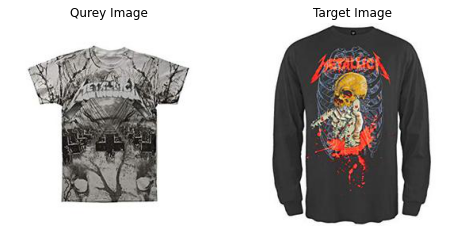

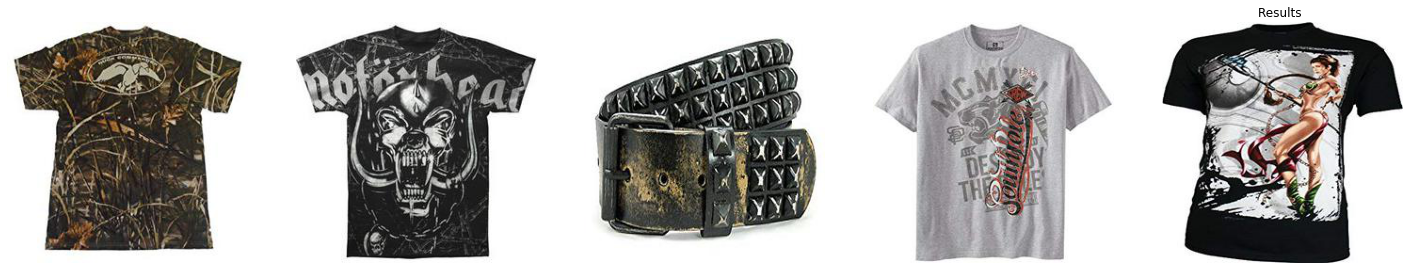

In [ ]:
show_source(100),show_result_all(get_result(nn_result_ImgOnly_Effi[100]))

Textual Query =     is gray and black <AND> black and gray with button neck and large front print  
50


(None, None)

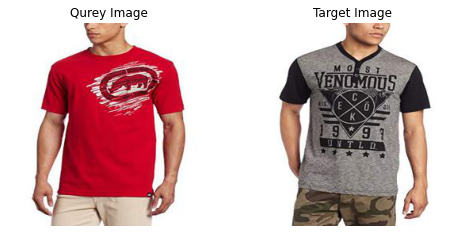

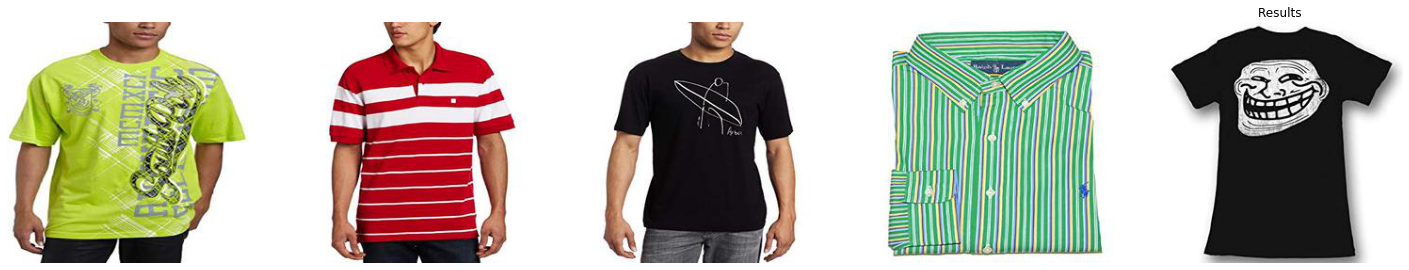

In [ ]:
show_source(65),show_result_all(get_result(nn_result_ImgOnly_Effi[65]))

Textual Query =     is red and a tshirt <AND> more warmer colors  
50


(None, None)

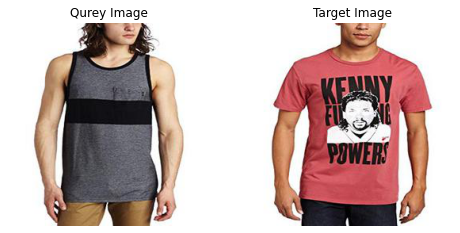

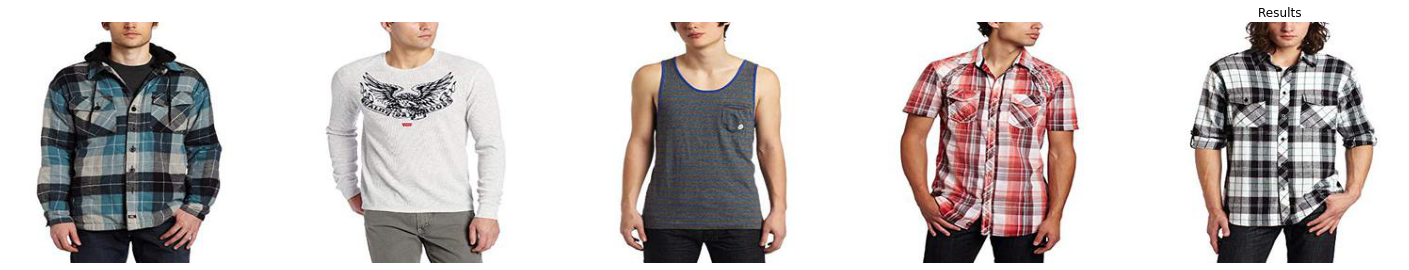

In [ ]:
show_source(1),show_result_all(get_result(nn_result_ImgOnly_Effi[1]))

Textual Query =     is a lighter color with a cat graphic <AND> is lighter and more graphic  
50


(None, None)

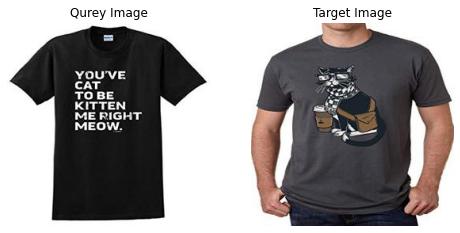

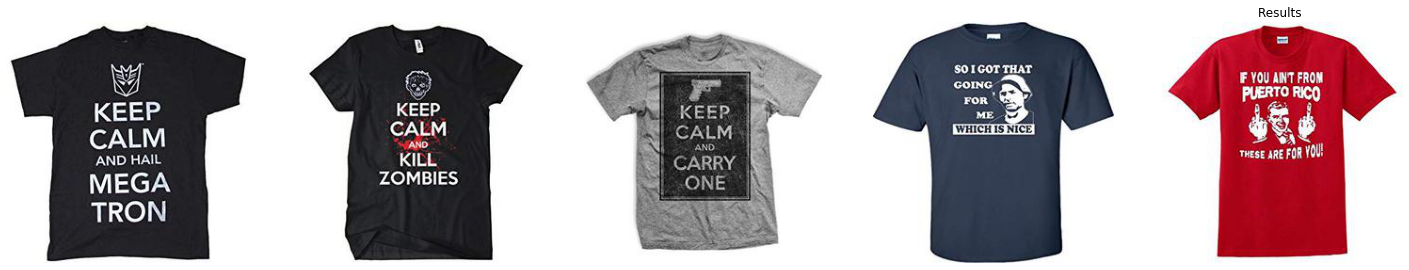

In [ ]:
show_source(30),show_result_all(get_result(nn_result_ImgOnly_Effi[30]))

# **Image Only ResNet 50**

In [ ]:
def parse_opt():
  """Parses the input arguments."""
  parser = argparse.ArgumentParser()
  parser.add_argument('-f', type=str, default='')
  parser.add_argument('--dataset', type=str, default='fashioniq')
  parser.add_argument('--root_dir', type=str, default='./{}')
  parser.add_argument('--log_dir', type=str, default='./runs')
  parser.add_argument('--model', type=str, default='imgonly')
  parser.add_argument('--img_encoder', type=str, default='resnet50')
  parser.add_argument('--text_encoder', type=str, default='lstm')
  parser.add_argument('--embed_dim', type=int, default=1024)
  parser.add_argument('--optimizer', type=str, default='Adam') # SGD Adam
  parser.add_argument('--learning_rate', type=float, default=1e-4)
  parser.add_argument(
      '--learning_rate_decay_patient', type=int, default=5)
  parser.add_argument('--eval_frequency', type=int, default=1)
  parser.add_argument('--lr_div', type=float, default=0.5) # 0.1
  parser.add_argument('--batch_size', type=int, default=32)
  parser.add_argument('--weight_decay', type=float, default=1e-6)
  parser.add_argument('--num_epoch', type=int, default=15)
  parser.add_argument('--loss', type=str, default='batch_based_classification')
  parser.add_argument('--loader_num_workers', type=int, default=2)
  #parser.add_argument('--is_test', default=False, action='store_true')
  #parser.add_argument('--return_test_rank', default=False, action='store_true')
  #parser.add_argument('--resume_file', default=None)
  parser.add_argument('--resume_file', default='./runs/best_checkpoint.pth')
  
  args = parser.parse_args()
  return args
opt = parse_opt()

Training

In [ ]:
model, optimizer = create_model_and_optimizer(opt, None)
# if opt.resume_file != None:
#   load_state_dicts(opt, model)

start_time = time.time()
df_loss_ImgOnly_res, df_R_mean_ImgOnly_res= train_loop(opt, logger, trainset, model, optimizer)    
shirt_time.append(time.time() - start_time)
logger.close()
df_loss_ImgOnly_res.head()


Creating model and optimizer for imgonly


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Begin training


Training for epoch 0: 100%|██████████| 187/187 [04:17<00:00,  1.38s/it]


It 187 epoch 0 Elapsed time 257.2291
    Loss batch_based_classification 2.7764
    Loss total training loss 2.7764


100%|██████████| 3443/3443 [00:23<00:00, 145.64it/s]


     shirt_r1 7.43
     shirt_r3 9.41
     shirt_r5 13.37
     shirt_r10 17.33
     shirt_r20 25.25
     shirt_r50 34.16
     rmean 17.82


Training for epoch 1: 100%|██████████| 187/187 [04:16<00:00,  1.37s/it]


It 374 epoch 1 Elapsed time 282.6232
    Loss batch_based_classification 2.4298
    Loss total training loss 2.4298


100%|██████████| 3443/3443 [00:23<00:00, 145.88it/s]


     shirt_r1 5.45
     shirt_r3 10.4
     shirt_r5 14.85
     shirt_r10 20.3
     shirt_r20 28.22
     shirt_r50 37.62
     rmean 19.47


Training for epoch 2: 100%|██████████| 187/187 [04:16<00:00,  1.37s/it]


It 561 epoch 2 Elapsed time 282.7488
    Loss batch_based_classification 2.1458
    Loss total training loss 2.1458


100%|██████████| 3443/3443 [00:23<00:00, 145.61it/s]


     shirt_r1 6.44
     shirt_r3 11.39
     shirt_r5 16.34
     shirt_r10 26.24
     shirt_r20 36.14
     shirt_r50 46.04
     rmean 23.76


Training for epoch 3: 100%|██████████| 187/187 [04:16<00:00,  1.37s/it]


It 748 epoch 3 Elapsed time 282.9939
    Loss batch_based_classification 1.8593
    Loss total training loss 1.8593


100%|██████████| 3443/3443 [00:23<00:00, 145.16it/s]


     shirt_r1 8.91
     shirt_r3 15.84
     shirt_r5 20.79
     shirt_r10 30.2
     shirt_r20 38.61
     shirt_r50 57.43
     rmean 28.63


Training for epoch 4: 100%|██████████| 187/187 [04:16<00:00,  1.37s/it]


It 935 epoch 4 Elapsed time 282.8191
    Loss batch_based_classification 1.5828
    Loss total training loss 1.5828


100%|██████████| 3443/3443 [00:23<00:00, 145.63it/s]


     shirt_r1 14.36
     shirt_r3 22.28
     shirt_r5 28.22
     shirt_r10 37.13
     shirt_r20 46.53
     shirt_r50 61.88
     rmean 35.07


Training for epoch 5: 100%|██████████| 187/187 [04:16<00:00,  1.37s/it]


It 1122 epoch 5 Elapsed time 282.6923
    Loss batch_based_classification 1.3136
    Loss total training loss 1.3136


100%|██████████| 3443/3443 [00:23<00:00, 145.52it/s]


     shirt_r1 11.88
     shirt_r3 24.26
     shirt_r5 30.69
     shirt_r10 41.58
     shirt_r20 53.96
     shirt_r50 71.29
     rmean 38.94


Training for epoch 6: 100%|██████████| 187/187 [04:16<00:00,  1.37s/it]


It 1309 epoch 6 Elapsed time 282.6172
    Loss batch_based_classification 1.0582
    Loss total training loss 1.0582


100%|██████████| 3443/3443 [00:23<00:00, 145.65it/s]


     shirt_r1 17.82
     shirt_r3 29.21
     shirt_r5 37.62
     shirt_r10 50.99
     shirt_r20 64.36
     shirt_r50 81.19
     rmean 46.86


Training for epoch 7: 100%|██████████| 187/187 [04:16<00:00,  1.37s/it]


It 1496 epoch 7 Elapsed time 282.818
    Loss batch_based_classification 0.8121
    Loss total training loss 0.8121


100%|██████████| 3443/3443 [00:23<00:00, 145.82it/s]


     shirt_r1 20.79
     shirt_r3 36.63
     shirt_r5 44.55
     shirt_r10 62.38
     shirt_r20 76.24
     shirt_r50 87.62
     rmean 54.7


Training for epoch 8: 100%|██████████| 187/187 [04:16<00:00,  1.37s/it]


It 1683 epoch 8 Elapsed time 282.7864
    Loss batch_based_classification 0.6585
    Loss total training loss 0.6585


100%|██████████| 3443/3443 [00:23<00:00, 145.68it/s]


     shirt_r1 26.24
     shirt_r3 46.04
     shirt_r5 55.45
     shirt_r10 68.32
     shirt_r20 78.22
     shirt_r50 90.1
     rmean 60.73


Training for epoch 9: 100%|██████████| 187/187 [04:16<00:00,  1.37s/it]


It 1870 epoch 9 Elapsed time 282.7637
    Loss batch_based_classification 0.5045
    Loss total training loss 0.5045


100%|██████████| 3443/3443 [00:23<00:00, 146.13it/s]


     shirt_r1 28.71
     shirt_r3 52.97
     shirt_r5 64.36
     shirt_r10 75.25
     shirt_r20 84.16
     shirt_r50 94.06
     rmean 66.58


Training for epoch 10: 100%|██████████| 187/187 [04:16<00:00,  1.37s/it]


It 2057 epoch 10 Elapsed time 282.6386
    Loss batch_based_classification 0.4069
    Loss total training loss 0.4069


100%|██████████| 3443/3443 [00:23<00:00, 145.43it/s]


     shirt_r1 33.17
     shirt_r3 57.92
     shirt_r5 69.8
     shirt_r10 84.16
     shirt_r20 91.09
     shirt_r50 97.52
     rmean 72.28


Training for epoch 11: 100%|██████████| 187/187 [04:16<00:00,  1.37s/it]


It 2244 epoch 11 Elapsed time 282.6953
    Loss batch_based_classification 0.3304
    Loss total training loss 0.3304


100%|██████████| 3443/3443 [00:23<00:00, 146.14it/s]


     shirt_r1 43.07
     shirt_r3 67.33
     shirt_r5 77.23
     shirt_r10 86.63
     shirt_r20 94.55
     shirt_r50 99.5
     rmean 78.05


Training for epoch 12: 100%|██████████| 187/187 [04:16<00:00,  1.37s/it]


It 2431 epoch 12 Elapsed time 282.6363
    Loss batch_based_classification 0.297
    Loss total training loss 0.297


100%|██████████| 3443/3443 [00:23<00:00, 146.22it/s]


     shirt_r1 46.04
     shirt_r3 70.79
     shirt_r5 77.72
     shirt_r10 87.13
     shirt_r20 95.05
     shirt_r50 98.51
     rmean 79.21


Training for epoch 13: 100%|██████████| 187/187 [04:16<00:00,  1.37s/it]


It 2618 epoch 13 Elapsed time 282.5345
    Loss batch_based_classification 0.2472
    Loss total training loss 0.2472


100%|██████████| 3443/3443 [00:23<00:00, 146.23it/s]


     shirt_r1 45.54
     shirt_r3 72.28
     shirt_r5 82.18
     shirt_r10 87.62
     shirt_r20 97.03
     shirt_r50 99.5
     rmean 80.69


Training for epoch 14: 100%|██████████| 187/187 [04:16<00:00,  1.37s/it]


It 2805 epoch 14 Elapsed time 282.4387
    Loss batch_based_classification 0.2126
    Loss total training loss 0.2126


100%|██████████| 3443/3443 [00:23<00:00, 145.97it/s]


     shirt_r1 53.96
     shirt_r3 79.21
     shirt_r5 83.17
     shirt_r10 94.06
     shirt_r20 97.52
     shirt_r50 99.01
     rmean 84.49
Finished training


epoch  batch_based_classification  total training loss
0    0.0                     2.77645              2.77645
1    1.0                     2.42976              2.42976
2    2.0                     2.14580              2.14580
3    3.0                     1.85935              1.85935
4    4.0                     1.58278              1.58278

In [ ]:
df_loss_ImgOnly_res

epoch  batch_based_classification  total training loss
0     0.0                     2.77645              2.77645
1     1.0                     2.42976              2.42976
2     2.0                     2.14580              2.14580
3     3.0                     1.85935              1.85935
4     4.0                     1.58278              1.58278
5     5.0                     1.31363              1.31363
6     6.0                     1.05816              1.05816
7     7.0                     0.81210              0.81210
8     8.0                     0.65854              0.65854
9     9.0                     0.50449              0.50449
10   10.0                     0.40694              0.40694
11   11.0                     0.33043              0.33043
12   12.0                     0.29697              0.29697
13   13.0                     0.24724              0.24724
14   14.0                     0.21256              0.21256

In [ ]:
df_R_mean_ImgOnly_res

epoch  Recall_Mean
0     0.0    17.821782
1     1.0    19.471947
2     2.0    23.762376
3     3.0    28.630363
4     4.0    35.066007
5     5.0    38.943894
6     6.0    46.864686
7     7.0    54.702970
8     8.0    60.726073
9     9.0    66.584158
10   10.0    72.277228
11   11.0    78.052805
12   12.0    79.207921
13   13.0    80.693069
14   14.0    84.488449

In [ ]:
shirt_time

[1832.0176117420197, 3059.7208371162415, 4241.031887054443]

**Testing**

In [ ]:
model, optimizer = create_model_and_optimizer(opt, None)
# state_dicts = torch.load(opt.resume_file, map_location=lambda storage, loc: storage)['model_state_dict']
# model.load_state_dict(state_dicts)
nn_result_ImgOnly_res=test(opt, testset, model)


Begin testing


100%|██████████| 2191/2191 [00:15<00:00, 145.96it/s]


     shirt_r1 1.91
     shirt_r3 3.44
     shirt_r5 4.58
     shirt_r10 8.02
     shirt_r20 10.31
     shirt_r50 14.89
     RecallMean 7.19
Finished testing


**Qualitative Results**

Textual Query =     is a lighter color with a cat graphic <AND> is lighter and more graphic  
50


(None, None)

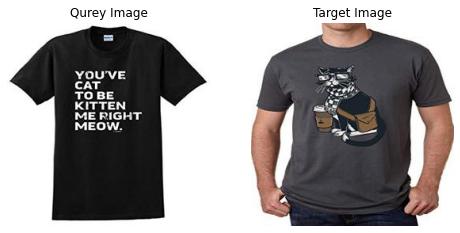

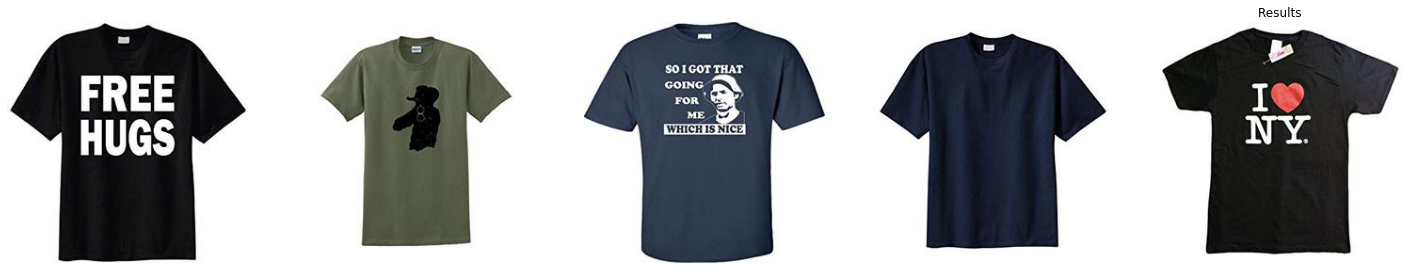

In [ ]:
show_source(30),show_result_all(get_result(nn_result_ImgOnly_res[30]))

Textual Query =     is red and a tshirt <AND> more warmer colors  
50


(None, None)

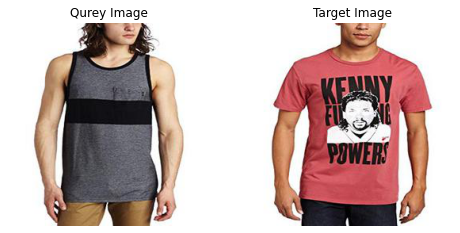

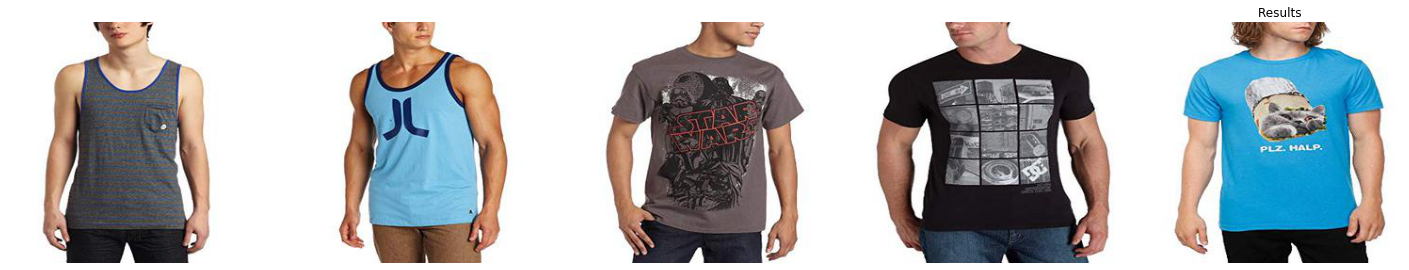

In [ ]:
show_source(1),show_result_all(get_result(nn_result_ImgOnly_res[1]))

# **TIRG**

In [ ]:
def parse_opt():
  """Parses the input arguments."""
  parser = argparse.ArgumentParser()
  parser.add_argument('-f', type=str, default='')
  parser.add_argument('--dataset', type=str, default='fashioniq')
  parser.add_argument('--root_dir', type=str, default='./{}')
  parser.add_argument('--log_dir', type=str, default='./runs')
  parser.add_argument('--model', type=str, default='tirg')
  parser.add_argument('--img_encoder', type=str, default='efficientnet')
  parser.add_argument('--text_encoder', type=str, default='lstm')
  parser.add_argument('--embed_dim', type=int, default=1024)
  parser.add_argument('--optimizer', type=str, default='Adam') # SGD Adam
  parser.add_argument('--learning_rate', type=float, default=1e-4)
  parser.add_argument(
      '--learning_rate_decay_patient', type=int, default=5)
  parser.add_argument('--eval_frequency', type=int, default=1)
  parser.add_argument('--lr_div', type=float, default=0.5) # 0.1
  parser.add_argument('--batch_size', type=int, default=32)
  parser.add_argument('--weight_decay', type=float, default=1e-6)
  parser.add_argument('--num_epoch', type=int, default=18)
  parser.add_argument('--loss', type=str, default='batch_based_classification')
  parser.add_argument('--loader_num_workers', type=int, default=2)
  parser.add_argument('--resume_file', default='./runs/best_checkpoint.pth')
  
  args = parser.parse_args()
  return args
opt = parse_opt()

Training

In [ ]:
model, optimizer = create_model_and_optimizer(opt, None)

start_time = time.time()
df_loss_tirg, df_R_mean_tirg= train_loop(opt, logger, trainset, model, optimizer)    
shirt_time.append(time.time() - start_time)
print("Total Time",Dress_time)
logger.close()
df_loss_tirg.head()



Creating model and optimizer for tirg
Loaded pretrained weights for efficientnet-b0
Begin training


Training for epoch 0: 100%|██████████| 187/187 [27:22<00:00,  8.78s/it]


It 187 epoch 0 Elapsed time 1642.0875
    Loss batch_based_classification 2.7396
    Loss total training loss 2.7396


100%|██████████| 3443/3443 [00:16<00:00, 212.75it/s]


     shirt_r1 4.46
     shirt_r3 10.89
     shirt_r5 14.36
     shirt_r10 22.77
     shirt_r20 30.2
     shirt_r50 42.08
     rmean 20.79


Training for epoch 1: 100%|██████████| 187/187 [03:17<00:00,  1.06s/it]


It 374 epoch 1 Elapsed time 218.0004
    Loss batch_based_classification 1.8929
    Loss total training loss 1.8929


100%|██████████| 3443/3443 [00:16<00:00, 214.28it/s]


     shirt_r1 12.38
     shirt_r3 21.29
     shirt_r5 28.22
     shirt_r10 37.13
     shirt_r20 46.04
     shirt_r50 59.41
     rmean 34.08


Training for epoch 2: 100%|██████████| 187/187 [03:17<00:00,  1.06s/it]


It 561 epoch 2 Elapsed time 215.233
    Loss batch_based_classification 1.394
    Loss total training loss 1.394


100%|██████████| 3443/3443 [00:16<00:00, 214.39it/s]


     shirt_r1 11.39
     shirt_r3 28.71
     shirt_r5 35.15
     shirt_r10 45.54
     shirt_r20 58.42
     shirt_r50 73.27
     rmean 42.08


Training for epoch 3: 100%|██████████| 187/187 [03:17<00:00,  1.05s/it]


It 748 epoch 3 Elapsed time 214.87
    Loss batch_based_classification 1.1098
    Loss total training loss 1.1098


100%|██████████| 3443/3443 [00:15<00:00, 217.31it/s]


     shirt_r1 16.83
     shirt_r3 28.71
     shirt_r5 38.12
     shirt_r10 52.97
     shirt_r20 65.84
     shirt_r50 82.67
     rmean 47.52


Training for epoch 4: 100%|██████████| 187/187 [03:17<00:00,  1.05s/it]


It 935 epoch 4 Elapsed time 214.7096
    Loss batch_based_classification 0.9059
    Loss total training loss 0.9059


100%|██████████| 3443/3443 [00:16<00:00, 214.99it/s]


     shirt_r1 22.28
     shirt_r3 41.09
     shirt_r5 48.51
     shirt_r10 60.89
     shirt_r20 74.26
     shirt_r50 88.12
     rmean 55.86


Training for epoch 5: 100%|██████████| 187/187 [03:17<00:00,  1.05s/it]


It 1122 epoch 5 Elapsed time 214.8344
    Loss batch_based_classification 0.769
    Loss total training loss 0.769


100%|██████████| 3443/3443 [00:15<00:00, 217.22it/s]


     shirt_r1 24.75
     shirt_r3 46.53
     shirt_r5 56.44
     shirt_r10 65.35
     shirt_r20 83.17
     shirt_r50 89.6
     rmean 60.97


Training for epoch 6: 100%|██████████| 187/187 [03:17<00:00,  1.05s/it]


It 1309 epoch 6 Elapsed time 214.7379
    Loss batch_based_classification 0.637
    Loss total training loss 0.637


100%|██████████| 3443/3443 [00:15<00:00, 216.30it/s]


     shirt_r1 32.18
     shirt_r3 52.97
     shirt_r5 61.39
     shirt_r10 76.24
     shirt_r20 89.11
     shirt_r50 95.05
     rmean 67.82


Training for epoch 7: 100%|██████████| 187/187 [03:17<00:00,  1.05s/it]


It 1496 epoch 7 Elapsed time 214.7725
    Loss batch_based_classification 0.5502
    Loss total training loss 0.5502


100%|██████████| 3443/3443 [00:15<00:00, 218.61it/s]


     shirt_r1 42.08
     shirt_r3 61.39
     shirt_r5 73.76
     shirt_r10 86.14
     shirt_r20 92.57
     shirt_r50 97.52
     rmean 75.58


Training for epoch 8: 100%|██████████| 187/187 [03:16<00:00,  1.05s/it]


It 1683 epoch 8 Elapsed time 214.3105
    Loss batch_based_classification 0.4673
    Loss total training loss 0.4673


100%|██████████| 3443/3443 [00:15<00:00, 216.64it/s]


     shirt_r1 45.05
     shirt_r3 74.26
     shirt_r5 80.69
     shirt_r10 91.58
     shirt_r20 96.53
     shirt_r50 98.51
     rmean 81.11


Training for epoch 9: 100%|██████████| 187/187 [03:17<00:00,  1.05s/it]


It 1870 epoch 9 Elapsed time 214.6789
    Loss batch_based_classification 0.4015
    Loss total training loss 0.4015


100%|██████████| 3443/3443 [00:15<00:00, 218.41it/s]


     shirt_r1 58.91
     shirt_r3 78.71
     shirt_r5 85.64
     shirt_r10 89.6
     shirt_r20 98.02
     shirt_r50 99.5
     rmean 85.07


Training for epoch 10: 100%|██████████| 187/187 [03:16<00:00,  1.05s/it]


It 2057 epoch 10 Elapsed time 214.4245
    Loss batch_based_classification 0.354
    Loss total training loss 0.354


100%|██████████| 3443/3443 [00:15<00:00, 217.46it/s]


     shirt_r1 60.4
     shirt_r3 82.18
     shirt_r5 89.6
     shirt_r10 96.53
     shirt_r20 99.5
     shirt_r50 100.0
     rmean 88.04


Training for epoch 11: 100%|██████████| 187/187 [03:16<00:00,  1.05s/it]


It 2244 epoch 11 Elapsed time 214.3145
    Loss batch_based_classification 0.316
    Loss total training loss 0.316


100%|██████████| 3443/3443 [00:15<00:00, 218.54it/s]


     shirt_r1 66.83
     shirt_r3 86.14
     shirt_r5 91.09
     shirt_r10 97.03
     shirt_r20 98.51
     shirt_r50 100.0
     rmean 89.93


Training for epoch 12: 100%|██████████| 187/187 [03:17<00:00,  1.05s/it]


It 2431 epoch 12 Elapsed time 214.5381
    Loss batch_based_classification 0.2719
    Loss total training loss 0.2719


100%|██████████| 3443/3443 [00:15<00:00, 218.34it/s]


     shirt_r1 69.31
     shirt_r3 87.62
     shirt_r5 94.06
     shirt_r10 98.02
     shirt_r20 99.5
     shirt_r50 100.0
     rmean 91.42


Training for epoch 13: 100%|██████████| 187/187 [03:16<00:00,  1.05s/it]


It 2618 epoch 13 Elapsed time 214.3588
    Loss batch_based_classification 0.2614
    Loss total training loss 0.2614


100%|██████████| 3443/3443 [00:15<00:00, 218.95it/s]


     shirt_r1 75.25
     shirt_r3 90.59
     shirt_r5 95.54
     shirt_r10 99.01
     shirt_r20 100.0
     shirt_r50 100.0
     rmean 93.4


Training for epoch 14: 100%|██████████| 187/187 [03:16<00:00,  1.05s/it]


It 2805 epoch 14 Elapsed time 214.1714
    Loss batch_based_classification 0.2265
    Loss total training loss 0.2265


100%|██████████| 3443/3443 [00:15<00:00, 219.13it/s]


     shirt_r1 80.69
     shirt_r3 97.52
     shirt_r5 99.5
     shirt_r10 100.0
     shirt_r20 100.0
     shirt_r50 100.0
     rmean 96.29


Training for epoch 15: 100%|██████████| 187/187 [03:16<00:00,  1.05s/it]


It 2992 epoch 15 Elapsed time 214.1761
    Loss batch_based_classification 0.2056
    Loss total training loss 0.2056


100%|██████████| 3443/3443 [00:15<00:00, 218.87it/s]


     shirt_r1 78.22
     shirt_r3 96.04
     shirt_r5 98.02
     shirt_r10 99.5
     shirt_r20 100.0
     shirt_r50 100.0
     rmean 95.3


Training for epoch 16: 100%|██████████| 187/187 [03:16<00:00,  1.05s/it]


It 3179 epoch 16 Elapsed time 213.9134
    Loss batch_based_classification 0.1916
    Loss total training loss 0.1916


100%|██████████| 3443/3443 [00:15<00:00, 218.82it/s]


     shirt_r1 80.2
     shirt_r3 97.03
     shirt_r5 98.51
     shirt_r10 100.0
     shirt_r20 100.0
     shirt_r50 100.0
     rmean 95.96


Training for epoch 17: 100%|██████████| 187/187 [03:16<00:00,  1.05s/it]


It 3366 epoch 17 Elapsed time 213.7122
    Loss batch_based_classification 0.1791
    Loss total training loss 0.1791


100%|██████████| 3443/3443 [00:15<00:00, 219.39it/s]


     shirt_r1 83.17
     shirt_r3 95.05
     shirt_r5 98.02
     shirt_r10 100.0
     shirt_r20 100.0
     shirt_r50 100.0
     rmean 96.04
Finished training
Total Time []


epoch  batch_based_classification  total training loss
0    0.0                     2.73958              2.73958
1    1.0                     1.89290              1.89290
2    2.0                     1.39397              1.39397
3    3.0                     1.10978              1.10978
4    4.0                     0.90585              0.90585

In [ ]:
shirt_time

[5308.761677265167]

In [ ]:
df_loss_tirg

epoch  batch_based_classification  total training loss
0     0.0                     2.73958              2.73958
1     1.0                     1.89290              1.89290
2     2.0                     1.39397              1.39397
3     3.0                     1.10978              1.10978
4     4.0                     0.90585              0.90585
5     5.0                     0.76897              0.76897
6     6.0                     0.63699              0.63699
7     7.0                     0.55024              0.55024
8     8.0                     0.46728              0.46728
9     9.0                     0.40153              0.40153
10   10.0                     0.35398              0.35398
11   11.0                     0.31596              0.31596
12   12.0                     0.27188              0.27188
13   13.0                     0.26142              0.26142
14   14.0                     0.22651              0.22651
15   15.0                     0.20561              0.20561
16   16.0                     0.19161              0.19161
17   17.0                     0.17909              0.17909

In [ ]:
df_R_mean_tirg

epoch  Recall_Mean
0     0.0    20.792079
1     1.0    34.075908
2     2.0    42.079208
3     3.0    47.524752
4     4.0    55.858086
5     5.0    60.973597
6     6.0    67.821782
7     7.0    75.577558
8     8.0    81.105611
9     9.0    85.066007
10   10.0    88.036304
11   11.0    89.933993
12   12.0    91.419142
13   13.0    93.399340
14   14.0    96.287129
15   15.0    95.297030
16   16.0    95.957096
17   17.0    96.039604

**Testing**

In [ ]:
model, optimizer = create_model_and_optimizer(opt, None)
# state_dicts = torch.load(opt.resume_file, map_location=lambda storage, loc: storage)['model_state_dict']
# model.load_state_dict(state_dicts)
nn_result_tirg=test(opt, testset, model)


Begin testing


100%|██████████| 2191/2191 [00:10<00:00, 206.75it/s]


     shirt_r1 7.25
     shirt_r3 12.98
     shirt_r5 18.7
     shirt_r10 27.48
     shirt_r20 35.88
     shirt_r50 48.85
     RecallMean 25.19
Finished testing


**Qualitative Results**

Textual Query =     has long sleeves <AND> is long sleeved and has a colored graphic  
50


(None, None)

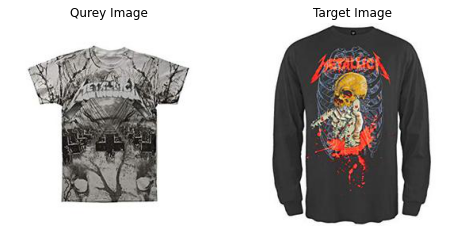

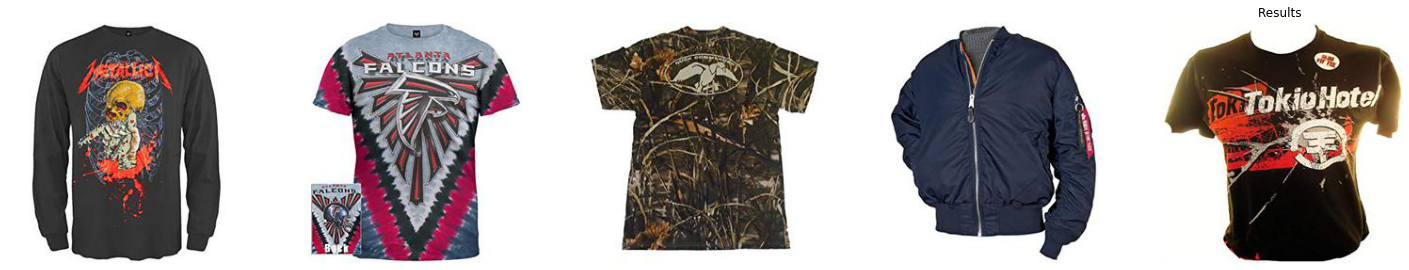

In [ ]:
show_source(100),show_result_all(get_result(nn_result_tirg[100]))

Textual Query =     is gray and black <AND> black and gray with button neck and large front print  
50


(None, None)

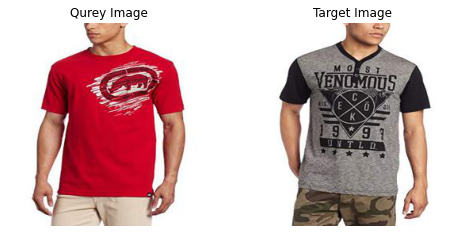

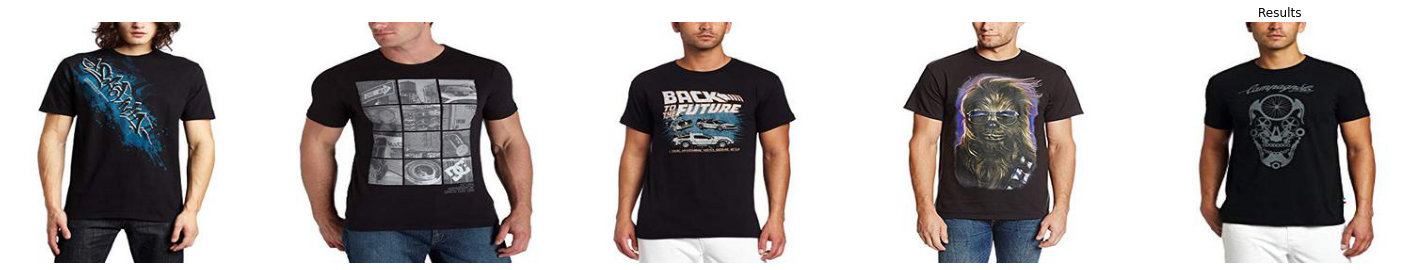

In [ ]:
show_source(65),show_result_all(get_result(nn_result_tirg[65]))

# Traning epoch vs losses

In [ ]:
df_loss_TextOnly=pd.DataFrame(columns=["epoch","batch_based_classification"])
df_R_mean_TextOnly=pd.DataFrame(columns=["epoch","Recall_Mean"])

df_loss_TextOnly['epoch']=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]
df_loss_TextOnly['batch_based_classification']=[3.11811, 2.22084, 1.79774, 1.51217, 1.30820, 1.13307, 1.00891, 0.86659, 0.80170, 0.69279, 0.60109, 0.53528, 0.47885, 0.45400, 0.41089]

df_R_mean_TextOnly['epoch']=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]
df_R_mean_TextOnly['Recall_Mean']= [9.735974, 21.039604, 26.485149, 33.745875, 41.584158, 47.689769, 54.537954, 61.221122, 66.336634, 72.029703, 76.732673, 78.052805, 83.828383, 86.303630, 88.118812]
# row=[epoch,batch_loss,training_loss]
# df_loss.loc[epoch] = row
df_loss_TextOnly

epoch  batch_based_classification
0     0.0                     3.11811
1     1.0                     2.22084
2     2.0                     1.79774
3     3.0                     1.51217
4     4.0                     1.30820
5     5.0                     1.13307
6     6.0                     1.00891
7     7.0                     0.86659
8     8.0                     0.80170
9     9.0                     0.69279
10   10.0                     0.60109
11   11.0                     0.53528
12   12.0                     0.47885
13   13.0                     0.45400
14   14.0                     0.41089

In [ ]:
df_R_mean_TextOnly

epoch  Recall_Mean
0     0.0     9.735974
1     1.0    21.039604
2     2.0    26.485149
3     3.0    33.745875
4     4.0    41.584158
5     5.0    47.689769
6     6.0    54.537954
7     7.0    61.221122
8     8.0    66.336634
9     9.0    72.029703
10   10.0    76.732673
11   11.0    78.052805
12   12.0    83.828383
13   13.0    86.303630
14   14.0    88.118812

In [ ]:
df_loss_ImgOnly_Effi=pd.DataFrame(columns=["epoch","batch_based_classification"])
df_R_mean_ImgOnly_Effi=pd.DataFrame(columns=["epoch","Recall_Mean"])

df_loss_ImgOnly_Effi['epoch']=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]
df_loss_ImgOnly_Effi['batch_based_classification']=[2.87506, 2.52570, 2.28071, 2.09258, 1.92138, 1.73715, 1.60092, 1.45881, 1.32965, 1.19737, 1.09660, 0.98594, 0.90528, 0.81549, 0.74217]

df_R_mean_ImgOnly_Effi['epoch']=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]
df_R_mean_ImgOnly_Effi['Recall_Mean']= [14.521452, 19.224422, 24.257426, 28.465347, 32.920792, 37.871287, 42.491749, 46.617162, 52.475248, 57.755776, 61.551155, 66.749175, 70.214521, 74.752475, 75.907591]
df_loss_ImgOnly_Effi

epoch  batch_based_classification
0     0.0                     2.87506
1     1.0                     2.52570
2     2.0                     2.28071
3     3.0                     2.09258
4     4.0                     1.92138
5     5.0                     1.73715
6     6.0                     1.60092
7     7.0                     1.45881
8     8.0                     1.32965
9     9.0                     1.19737
10   10.0                     1.09660
11   11.0                     0.98594
12   12.0                     0.90528
13   13.0                     0.81549
14   14.0                     0.74217

In [ ]:
df_R_mean_ImgOnly_Effi

epoch  Recall_Mean
0     0.0    14.521452
1     1.0    19.224422
2     2.0    24.257426
3     3.0    28.465347
4     4.0    32.920792
5     5.0    37.871287
6     6.0    42.491749
7     7.0    46.617162
8     8.0    52.475248
9     9.0    57.755776
10   10.0    61.551155
11   11.0    66.749175
12   12.0    70.214521
13   13.0    74.752475
14   14.0    75.907591

In [ ]:
df_loss_ImgOnly_res=pd.DataFrame(columns=["epoch","batch_based_classification"])
df_R_mean_ImgOnly_res=pd.DataFrame(columns=["epoch","Recall_Mean"])

df_loss_ImgOnly_res['epoch']=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]
df_loss_ImgOnly_res['batch_based_classification']=[2.77645, 2.42976, 2.14580, 1.85935, 1.58278, 1.31363, 1.05816, 0.81210, 0.65854, 0.50449, 0.40694, 0.33043, 0.29697, 0.24724, 0.21256]

df_R_mean_ImgOnly_res['epoch']=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]
df_R_mean_ImgOnly_res['Recall_Mean']= [17.821782, 19.471947, 23.762376, 28.630363, 35.066007, 38.943894, 46.864686, 54.702970, 60.726073, 66.584158, 72.277228, 78.052805, 79.207921, 80.693069, 84.488449]
df_loss_ImgOnly_res

epoch  batch_based_classification
0     0.0                     2.77645
1     1.0                     2.42976
2     2.0                     2.14580
3     3.0                     1.85935
4     4.0                     1.58278
5     5.0                     1.31363
6     6.0                     1.05816
7     7.0                     0.81210
8     8.0                     0.65854
9     9.0                     0.50449
10   10.0                     0.40694
11   11.0                     0.33043
12   12.0                     0.29697
13   13.0                     0.24724
14   14.0                     0.21256

In [ ]:
df_R_mean_ImgOnly_res

epoch  Recall_Mean
0     0.0    17.821782
1     1.0    19.471947
2     2.0    23.762376
3     3.0    28.630363
4     4.0    35.066007
5     5.0    38.943894
6     6.0    46.864686
7     7.0    54.702970
8     8.0    60.726073
9     9.0    66.584158
10   10.0    72.277228
11   11.0    78.052805
12   12.0    79.207921
13   13.0    80.693069
14   14.0    84.488449

In [ ]:
df_loss_tirg=pd.DataFrame(columns=["epoch","batch_based_classification"])
df_R_mean_tirg=pd.DataFrame(columns=["epoch","Recall_Mean"])

df_loss_tirg['epoch']=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]
df_loss_tirg['batch_based_classification']=[2.736, 1.872, 1.37, 1.107, 0.9123, 0.754, 0.643, 0.541, 0.465, 0.344, 0.3136, 0.278, 0.258, 0.228, 0.2068]

df_R_mean_tirg['epoch']=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]
df_R_mean_tirg['Recall_Mean']= [22.77, 32.18, 43.23, 48.43, 55.45, 63.12, 70.3, 72.85, 78.8, 82.67, 87.46, 89.6, 90.59, 93.4, 93.73]
df_loss_tirg

epoch  batch_based_classification
0     0.0                      2.7360
1     1.0                      1.8720
2     2.0                      1.3700
3     3.0                      1.1070
4     4.0                      0.9123
5     5.0                      0.7540
6     6.0                      0.6430
7     7.0                      0.5410
8     8.0                      0.4650
9     9.0                      0.3440
10   10.0                      0.3136
11   11.0                      0.2780
12   12.0                      0.2580
13   13.0                      0.2280
14   14.0                      0.2068

In [ ]:
df_R_mean_tirg

epoch  Recall_Mean
0     0.0        22.77
1     1.0        32.18
2     2.0        43.23
3     3.0        48.43
4     4.0        55.45
5     5.0        63.12
6     6.0        70.30
7     7.0        72.85
8     8.0        78.80
9     9.0        82.67
10   10.0        87.46
11   11.0        89.60
12   12.0        90.59
13   13.0        93.40
14   14.0        93.73

In [ ]:
# df_loss_TextOnly, df_R_mean_TextOnly
# df_loss_ImgOnly_Effi, df_R_mean_ImgOnly_Effi
# df_loss_ImgOnly_res, df_R_mean_ImgOnly_res
# df_loss_tirg, df_R_mean_tirg
#epoch	Recall_Mean

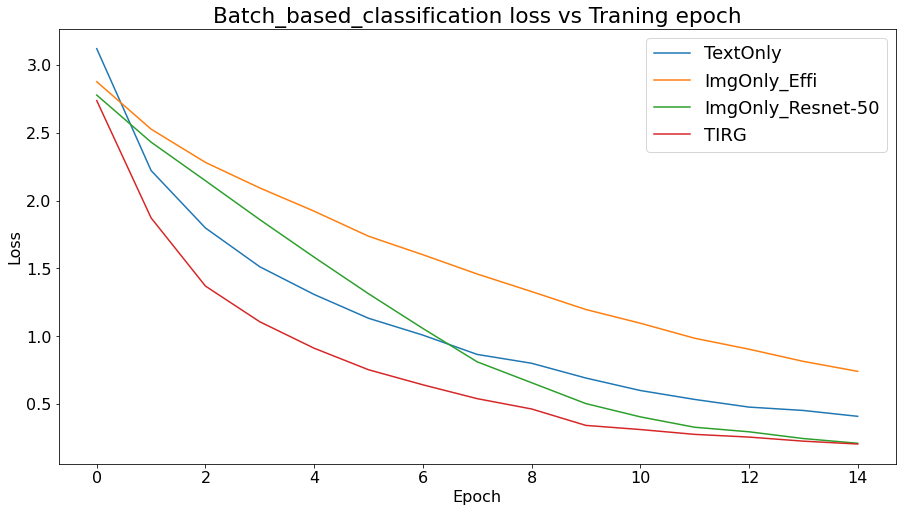

In [ ]:
#fig = figure(figsize = (15,10))
ax = plt.figure(figsize=(15,8)).gca()
plt.rcParams.update({'font.size': 18})
plt.plot(df_loss_TextOnly['epoch'], df_loss_TextOnly['batch_based_classification'], label = "TextOnly", linestyle="-")
plt.plot(df_loss_ImgOnly_Effi['epoch'], df_loss_ImgOnly_Effi['batch_based_classification'], label = "ImgOnly_Effi", linestyle="-")
plt.plot(df_loss_ImgOnly_res['epoch'], df_loss_ImgOnly_res['batch_based_classification'], label = "ImgOnly_Resnet-50", linestyle="-")
plt.plot(df_loss_tirg['epoch'], df_loss_tirg['batch_based_classification'], label = "TIRG", linestyle="-")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Batch_based_classification loss vs Traning epoch")
plt.show()


In [ ]:
# fig = figure(figsize = (12,6))
# ax = plt.figure(figsize=(15,8)).gca()
# plt.rcParams.update({'font.size': 16})
# plt.plot(df_loss_TextOnly['epoch'], df_loss_TextOnly['total training loss'], label = "TextOnly", linestyle="-")
# plt.plot(df_loss_ImgOnly_Effi['epoch'], df_loss_ImgOnly_Effi['total training loss'], label = "ImgOnly_Effi", linestyle="-")
# plt.plot(df_loss_ImgOnly_res['epoch'], df_loss_ImgOnly_res['total training loss'], label = "ImgOnly_Resnet-50", linestyle="-")
# plt.plot(df_loss_tirg['epoch'], df_loss_tirg['total training loss'], label = "TIRG", linestyle="-")
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.legend()
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("total training loss vs Traning epoch")
# plt.show()

# Recall Mean vs Training epoch

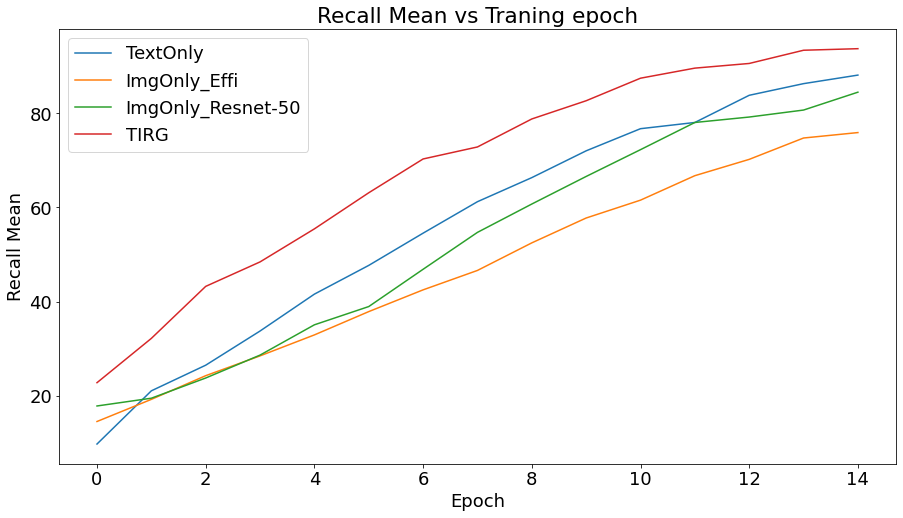

In [ ]:
ax = plt.figure(figsize=(15,8)).gca()
plt.rcParams.update({'font.size': 18})
plt.plot(df_R_mean_TextOnly['epoch'], df_R_mean_TextOnly['Recall_Mean'], label = "TextOnly", linestyle="-")
plt.plot(df_R_mean_ImgOnly_Effi['epoch'], df_R_mean_ImgOnly_Effi['Recall_Mean'], label = "ImgOnly_Effi", linestyle="-")
plt.plot(df_R_mean_ImgOnly_res['epoch'], df_R_mean_ImgOnly_res['Recall_Mean'], label = "ImgOnly_Resnet-50", linestyle="-")
plt.plot(df_R_mean_tirg['epoch'], df_R_mean_tirg['Recall_Mean'], label = "TIRG", linestyle="-")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Recall Mean")
plt.title("Recall Mean vs Traning epoch")
plt.show()

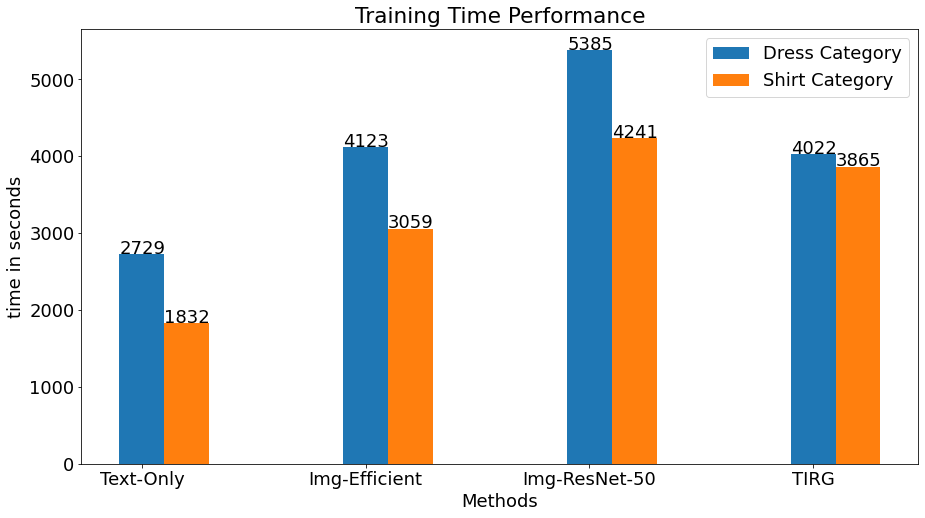

In [ ]:
#Time Graph
X = ['Text-Only','Img-Efficient','Img-ResNet-50','TIRG']
Dress_time= [2729, 4123, 5385, 4022]
shirt_time=[1832, 3059, 4241, 3865]
# Top_time = [20,30,25,30]
  
X_axis = np.arange(len(X))
ax = plt.figure(figsize=(15,8)).gca()
plt.rcParams.update({'font.size': 18})


bars1=plt.bar(X_axis, Dress_time, 0.2, label = 'Dress Category')
bars2=plt.bar(X_axis+0.2, shirt_time, 0.2, label = 'Shirt Category')

# for index, value in enumerate(Dress_time):
#     plt.text(value, index,
#              str(value))  
plt.xticks(X_axis, X)
plt.xlabel("Methods")
plt.ylabel("time in seconds")
plt.title("Training Time Performance")
plt.legend()
# for i, v in enumerate(Dress_time):
#     plt.text(i - 0.25, v + 0.01, str(v))
# for i, v in enumerate(shirt_time):
#     plt.text(i - 0.25, v + 0.01, str(v))
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 5, yval)
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 5, yval)

plt.show()

# **plot Recall**

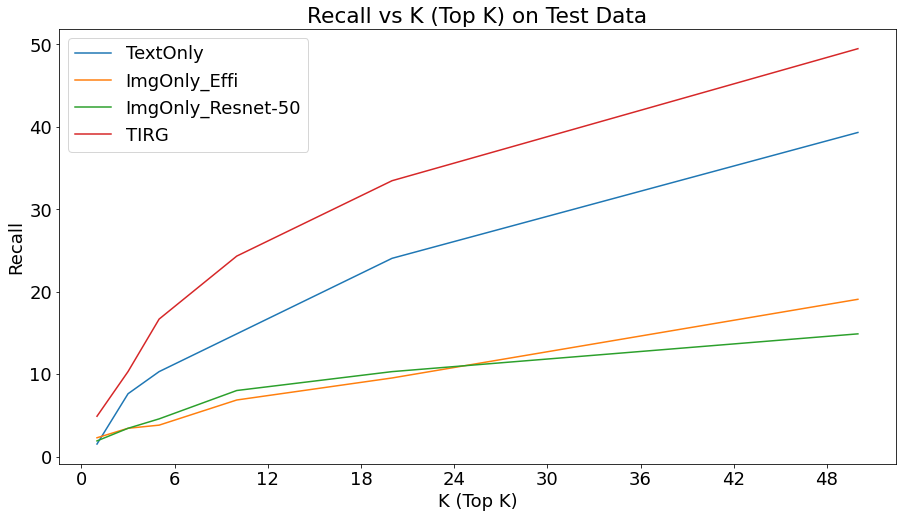

In [ ]:
Textonly= [1.53, 7.63, 10.31, 14.89, 24.05, 39.31]
Img_effi= [2.29, 3.44, 3.82, 6.87, 9.54, 19.08]
Img_res= [1.91, 3.44, 4.58, 8.02, 10.31, 14.89]
Tirg= [4.9, 10.32, 16.68, 24.32, 33.46, 49.47]
k=[1, 3, 5, 10, 20, 50]
#RecallMean= [17.18, 5.79, 5.14, 22.15]

ax = plt.figure(figsize=(15,8)).gca()
plt.rcParams.update({'font.size': 18})
plt.plot(k, Textonly, label = "TextOnly", linestyle="-")
plt.plot(k, Img_effi, label = "ImgOnly_Effi", linestyle="-")
plt.plot(k, Img_res, label = "ImgOnly_Resnet-50", linestyle="-")
plt.plot(k, Tirg, label = "TIRG", linestyle="-")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel("K (Top K)")
plt.ylabel("Recall")
plt.title("Recall vs K (Top K) on Test Data")
plt.show()

No handles with labels found to put in legend.


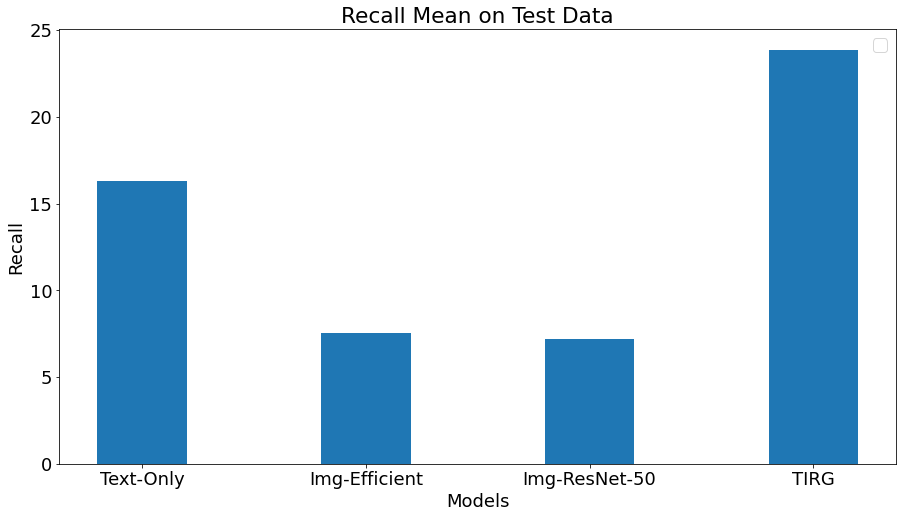

In [ ]:
X = ['Text-Only','Img-Efficient','Img-ResNet-50','TIRG']
RecallMean= [16.28, 7.51, 7.19, 23.87]  

ax = plt.figure(figsize=(15,8)).gca()
plt.rcParams.update({'font.size': 18})

X_axis = np.arange(len(X))
  
plt.bar(X_axis, RecallMean, 0.4)
  
plt.xticks(X_axis, X)
plt.xlabel("Models")
plt.ylabel("Recall")
plt.title("Recall Mean on Test Data")
plt.legend()
plt.show()